# Predicting ExoPlanet Discoverability based off Planetary Features 
## Phase 2: Statistical Modelling

#### Group Name: 40

#### Name(s) & ID(s) of Group Members:
Rafat Mahiuddin (s3897093)

Adrian Rebellato (s3889401)

Arthul George (S3918048)

## Table of Contents
- [Introduction](#intro)
  - [Phase 1 Summary](#ph1s)
  - [Report Overview](#Overview)
  - [Overview of Methodology](#methodology)
- [Data Processing](#data_processing)
  - [Module Imports](#mi)
  - [One Hot Encoding](#ohe)
  - [Data Normalisation](#dm) 
- [Statistical Modelling](#sm)
    - [Model Overview](#mo)
    - [Model Fitting](#mf)
    - [Feature Selection](#fs)
    - [Formula String](#fstring)
    - [Full Model Diagnostics Check](#dc)
    - [Calculating Residuals for model visualization](#mv)
- [Deep Neural Networks](#dnn)
  - [Import Statements](#is)
  - [Data Reprocessing for DNN](#drf)
  - [Outlier Processing for DNN](#opp)
  - [Apply Feature Selection and Column Processing for DNN](#fsc)
  - [Data Partition](#dpar)
  - [Target Feature Partition](#tfp)
  - [Data Normalisation](#dnorm)
  - [Plotting Functions](#pltf)
  - [DNN Model Build and Compilation](#build)
  - [DNN Model Training ](#train)
  - [Fine Tuning Plots](#tune)
  - [DNN Discussion (Literature)](#lit)
  - [DNN Structure](#struc)
  - [The Process Behind our DNN structure](#proc)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)
  - [Project Summary](#summ)
  - [Summary of Findings](#find)
  - [Conclusions](#concl)

## Introduction <a id='intro'></a>

### Phase 1 Summary <a id='ph1s'></a>

Phase 1 required us to process our data and approach the standard required for multiple linear regression modeling. We removed unnecessary columns, calculated new columns using data inferred from previous features, found outliers and dropped rows with missing values. We are left with almost 3000 rows, with no missing or unusual data.

Our goal is to explore what factors influence planet discoverability, by creating a Multiple Linear Regression model to predict planet radius. To facilitate this, we made two assumptions at the beginning of the study: That the distribution of exoplanets is independent of their distance from Earth, and that the radius of a planet is correlated with ease of discoverability. Our exploration suggests that the latter is true. We can also assume the former is true (until proven otherwise) as it is the simplest, and most agreed upon description of our universe accepted by astrophysicists. 

In phase 1, exploration into the relationships between features revealed a strong link between orbital distance and orbital period, distance from earth and parallax, and planet mass and radius. We also discovered how the number of exoplanets per star system dropped to 1 after 2500 parsecs. This further supports our assumptions. Finally, exploring the positional relationship between exoplanets revealed to us the Kepler mission, and how it dominated our dataset.

These relationships have helped inform the pre-processing we will conduct before creating the MLR model in Phase 2.

### Report Overview <a id='Overview'></a>


This report details the additional data processing required for multiple linear regression, Full and reduced MLR modelling, Diagnostics Checks for MLR modelling, Neural Network Fitting as well as a summary of our findings. 

Our goal is to accurately predict the planet radius using these modelling techniques.


### Overview of Methodology <a id='methodology'></a>


We explore our data using both Multiple Linear Regression and Neural Networks to predict the value of planet radius, in order to explore exoplanet discoverability. 

Multiple Linear Regression is a model that relies on multiple explanatory variables to predict a target feature. Below you can find the full model using all of our explanatory variables, as well as a reduced model which has utilized backwards feature selection to cull weaker explanatory variables.

The Multiple Linear Regression model predicts planet radius with an r-squared value of 0.4. This is not a strong prediction, so to develop a stronger model we used neural networks, which are explained further below.


## Data Processing <a id='data_processing'></a>


### Module Imports

In [1]:
import numpy as np
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set()
!pip install -q seaborn

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

df = pd.read_csv('Phase2_Group40.csv')
print('Before Rename:', df.columns.to_list())

# Rename columns to be compatible with patsy
df.rename({'semi-major_axis': 'semi_major_axis', '2_stars': 'two_stars'}, axis=1, inplace=True)
print("After Rename:")

# Remove particular variables for better study
df = df.drop(['planet_mass', 'latitude_gal', 'longitude_gal', 'mass_ratio_sys', 'radius_ratio_sys'], axis=1 )
df.head()

Before Rename: ['num_star', '2_stars', 'orbital_period', 'semi-major_axis', 'planet_radius', 'planet_mass', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'latitude_gal', 'longitude_gal', 'distance', 'parallax', 'mass_ratio_sys', 'radius_ratio_sys', 'num_planet']
After Rename:


num_star  two_stars  orbital_period  semi_major_axis  planet_radius  \
0         3          0    11688.000000         12.00000         13.400   
1         2          0       14.651600          0.11340         13.900   
2         2          0        0.736547          0.01544          1.875   
3         1          0        8.463000          0.06450          4.070   
4         1          0       18.859019          0.11010          3.240   

   planet_eccen  planet_temp  star_temp  star_radius  star_mass  star_bright  \
0          0.45        700.0     7295.0         1.49       1.65        0.752   
1          0.00        700.0     5172.0         0.94       0.91       -0.197   
2          0.05       1958.0     5172.0         0.94       0.91       -0.197   
3          0.00        593.0     3700.0         0.75       0.50       -1.046   
4          0.00        454.0     3700.0         0.75       0.50       -1.065   

   star_age  distance  parallax  num_planet  
0     0.020   29.7575   33.5770           1  
1     5.500   12.5855   79.4274           5  
2    10.200   12.5855   79.4274           5  
3     0.022    9.7221  102.8290           2  
4     0.022    9.7221  102.8290           2

### One Hot Encoding <a id='ohe'></a>


In [2]:
# Generate a copy for data modification
data_encoded = df.copy()

In [3]:
categorical_vars = [ "num_star", "two_stars", "num_planet"]

for var in categorical_vars:
    data_encoded = data_encoded.astype({var: object})

# Categorical encoding for less than 2 values
for col in data_encoded.columns:
    q = len(data_encoded[col].unique())
    if (q == 2):
        data_encoded[col] = pd.get_dummies(data_encoded[col], drop_first=True)
# For categorical features > 2 levels
data_encoded = pd.get_dummies(data_encoded)

print(f"There are {data_encoded.shape[1]} columns with the column names {data_encoded.columns.to_list()} after one hot encoding")

There are 25 columns with the column names ['two_stars', 'orbital_period', 'semi_major_axis', 'planet_radius', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'distance', 'parallax', 'num_star_1', 'num_star_2', 'num_star_3', 'num_star_4', 'num_planet_1', 'num_planet_2', 'num_planet_3', 'num_planet_4', 'num_planet_5', 'num_planet_6', 'num_planet_7', 'num_planet_8'] after one hot encoding


### Data Normalisation <a id='dm'></a>


In [4]:
"""
Due to the nature of our dataset, all uint8 types are considered categorical.
"""
# Perform normalisation on only the float types in df_float.
df_float = data_encoded.select_dtypes(include=['float64'])
df_float.drop('planet_radius', inplace=True, axis=1)
print(df_float.columns.to_list())
# TODO: Check if RobustScaler gives out better results
df_norm = MinMaxScaler().fit_transform(df_float)

print(f"The mean of each column in the df_norm dataframe is {np.round(df_norm.mean(axis=0),3)}")

['orbital_period', 'semi_major_axis', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'distance', 'parallax']
The mean of each column in the df_norm dataframe is [0.001 0.005 0.029 0.204 0.388 0.164 0.328 0.69  0.301 0.157 0.016]


In [5]:
data_encoded.loc[:, 
        ['orbital_period', 'semi_major_axis', 'planet_eccen',
         'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright',
         'star_age', 'distance', 'parallax'
        ]
        ] = pd.DataFrame(df_norm, columns=[
                                            'orbital_period', 'semi_major_axis', 
                                             'planet_eccen',
                                            'planet_temp', 'star_temp',
                                            'star_radius', 'star_mass',
                                            'star_bright', 'star_age',
                                            'distance', 'parallax'
                                            ])
data_encoded.sample(3)

two_stars  orbital_period  semi_major_axis  planet_radius  planet_eccen  \
1718          0        0.000091         0.001816           3.39           0.0   
1545          0        0.000084         0.001448           1.79           0.0   
2515          0        0.000070         0.001348           1.41           0.0   

      planet_temp  star_temp  star_radius  star_mass  star_bright  star_age  \
1718     0.296815   0.435429     0.292528   0.349442     0.803901  0.312143   
1545     0.209427   0.359153     0.146264   0.286245     0.716290  0.350000   
2515     0.204586   0.380721     0.135135   0.319703     0.668207  0.118571   

      distance  parallax  num_star_1  num_star_2  num_star_3  num_star_4  \
1718  0.284765  0.002968           1           0           0           0   
1545  0.197849  0.004094           1           0           0           0   
2515  0.117412  0.006610           1           0           0           0   

      num_planet_1  num_planet_2  num_planet_3  num_planet_4  num_planet_5  \
1718             0             1             0             0             0   
1545             0             0             1             0             0   
2515             1             0             0             0             0   

      num_planet_6  num_planet_7  num_planet_8  
1718             0             0             0  
1545             0             0             0  
2515             0             0             0

## Statistical Modelling <a id='sm'></a>


### Model Overview <a id='mo'></a>


Our first attempt at modelling our data will be a Multiple Linear Regression model using all of our explanatory variables.

First, a quick peek at the variables themselves:

In [46]:
df.columns.tolist()
import warnings
warnings.filterwarnings("ignore")

from tabulate import tabulate
table = [['Name','Data Type','Units','Description'],
         ['num_star', 'Nominal categorical', 'NA', 'Number of stars in the system'],
         ['num_planet', 'Nominal categorical', 'NA', 'Number of planets in the system'],
         ['two_stars', 'Nominal categorical', 'NA', 'Circumbinary flag: whether the planet orbits 2 stars'],
         ['orbital_period', 'Numeric', 'Earth days', 'Orbital period (Time it takes planet to complete an orbit'],
         ['semi_major_axis', 'Numeric', 'au', 'Orbit semi-Major Axis. au is the distance from Earth to sun.'],
         ['planet_radius', 'Numeric', 'Earth radius', 'Planet radius, where 1.0 is Earth\'s radius'],
         ['planet_eccen', 'Numeric', 'NA', 'Planet\s orbital eccentricity'],
         ['planet_temp', 'Numeric', 'Kelvin', 'Equilibrium Temperature: (The planetary equilibrium temperature is a the theoretical temperature that a planet would be a black body being heated only by its parent star)'],
         ['star_temp', 'Numeric', 'Kelvin', 'Stellar Effective Temperature'],
         ['star_radius', 'Numeric', 'Solar Radius', 'Stellar Radius, where 1.0 is 1 of our Sun\'s radius'],
         ['star_mass', 'Numeric', 'Solar Mass', 'Stellar Mass, where 1.0 is 1* our Sun\'s mass'],
         ['star_bright', 'Numeric', 'log(Solar luminosity)', 'Stellar Luminosity'],
         ['star_age', 'Numeric', 'gyr (Gigayear)', 'Stellar Age'],
         ['distance', 'Numeric', 'parsec', 'Distance'],
         ['parallax', 'Numeric', 'mas (miliarcseconds)', 'Parallax: Distance the star moves in relation to other objects in the night sky'],
        ]
print(tabulate(table, headers='firstrow', tablefmt='simple'))
print("\nOur target variable is planet_radius.")

Name             Data Type            Units                  Description
---------------  -------------------  ---------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------
num_star         Nominal categorical  NA                     Number of stars in the system
num_planet       Nominal categorical  NA                     Number of planets in the system
two_stars        Nominal categorical  NA                     Circumbinary flag: whether the planet orbits 2 stars
orbital_period   Numeric              Earth days             Orbital period (Time it takes planet to complete an orbit
semi_major_axis  Numeric              au                     Orbit semi-Major Axis. au is the distance from Earth to sun.
planet_radius    Numeric              Earth radius           Planet radius, where 1.0 is Earth's radius
planet_eccen     Numeric              NA            

### Model Fitting

Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.

#### Feature Selection

##### Formula String

In [6]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='planet_radius').columns)
formula_string_encoded = 'planet_radius ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  planet_radius ~ two_stars + orbital_period + semi_major_axis + planet_eccen + planet_temp + star_temp + star_radius + star_mass + star_bright + star_age + distance + parallax + num_star_1 + num_star_2 + num_star_3 + num_star_4 + num_planet_1 + num_planet_2 + num_planet_3 + num_planet_4 + num_planet_5 + num_planet_6 + num_planet_7 + num_planet_8


OLS model to encoded data

In [7]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)

model_full_fitted = model_full.fit()

print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:          planet_radius   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     97.92
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:33:04   Log-Likelihood:                -7750.8
No. Observations:                2895   AIC:                         1.555e+04
Df Residuals:                    2872   BIC:                         1.568e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9042      0.960     

Visualizing the accuracy of our model by plotting actual radius vs. predicted radius

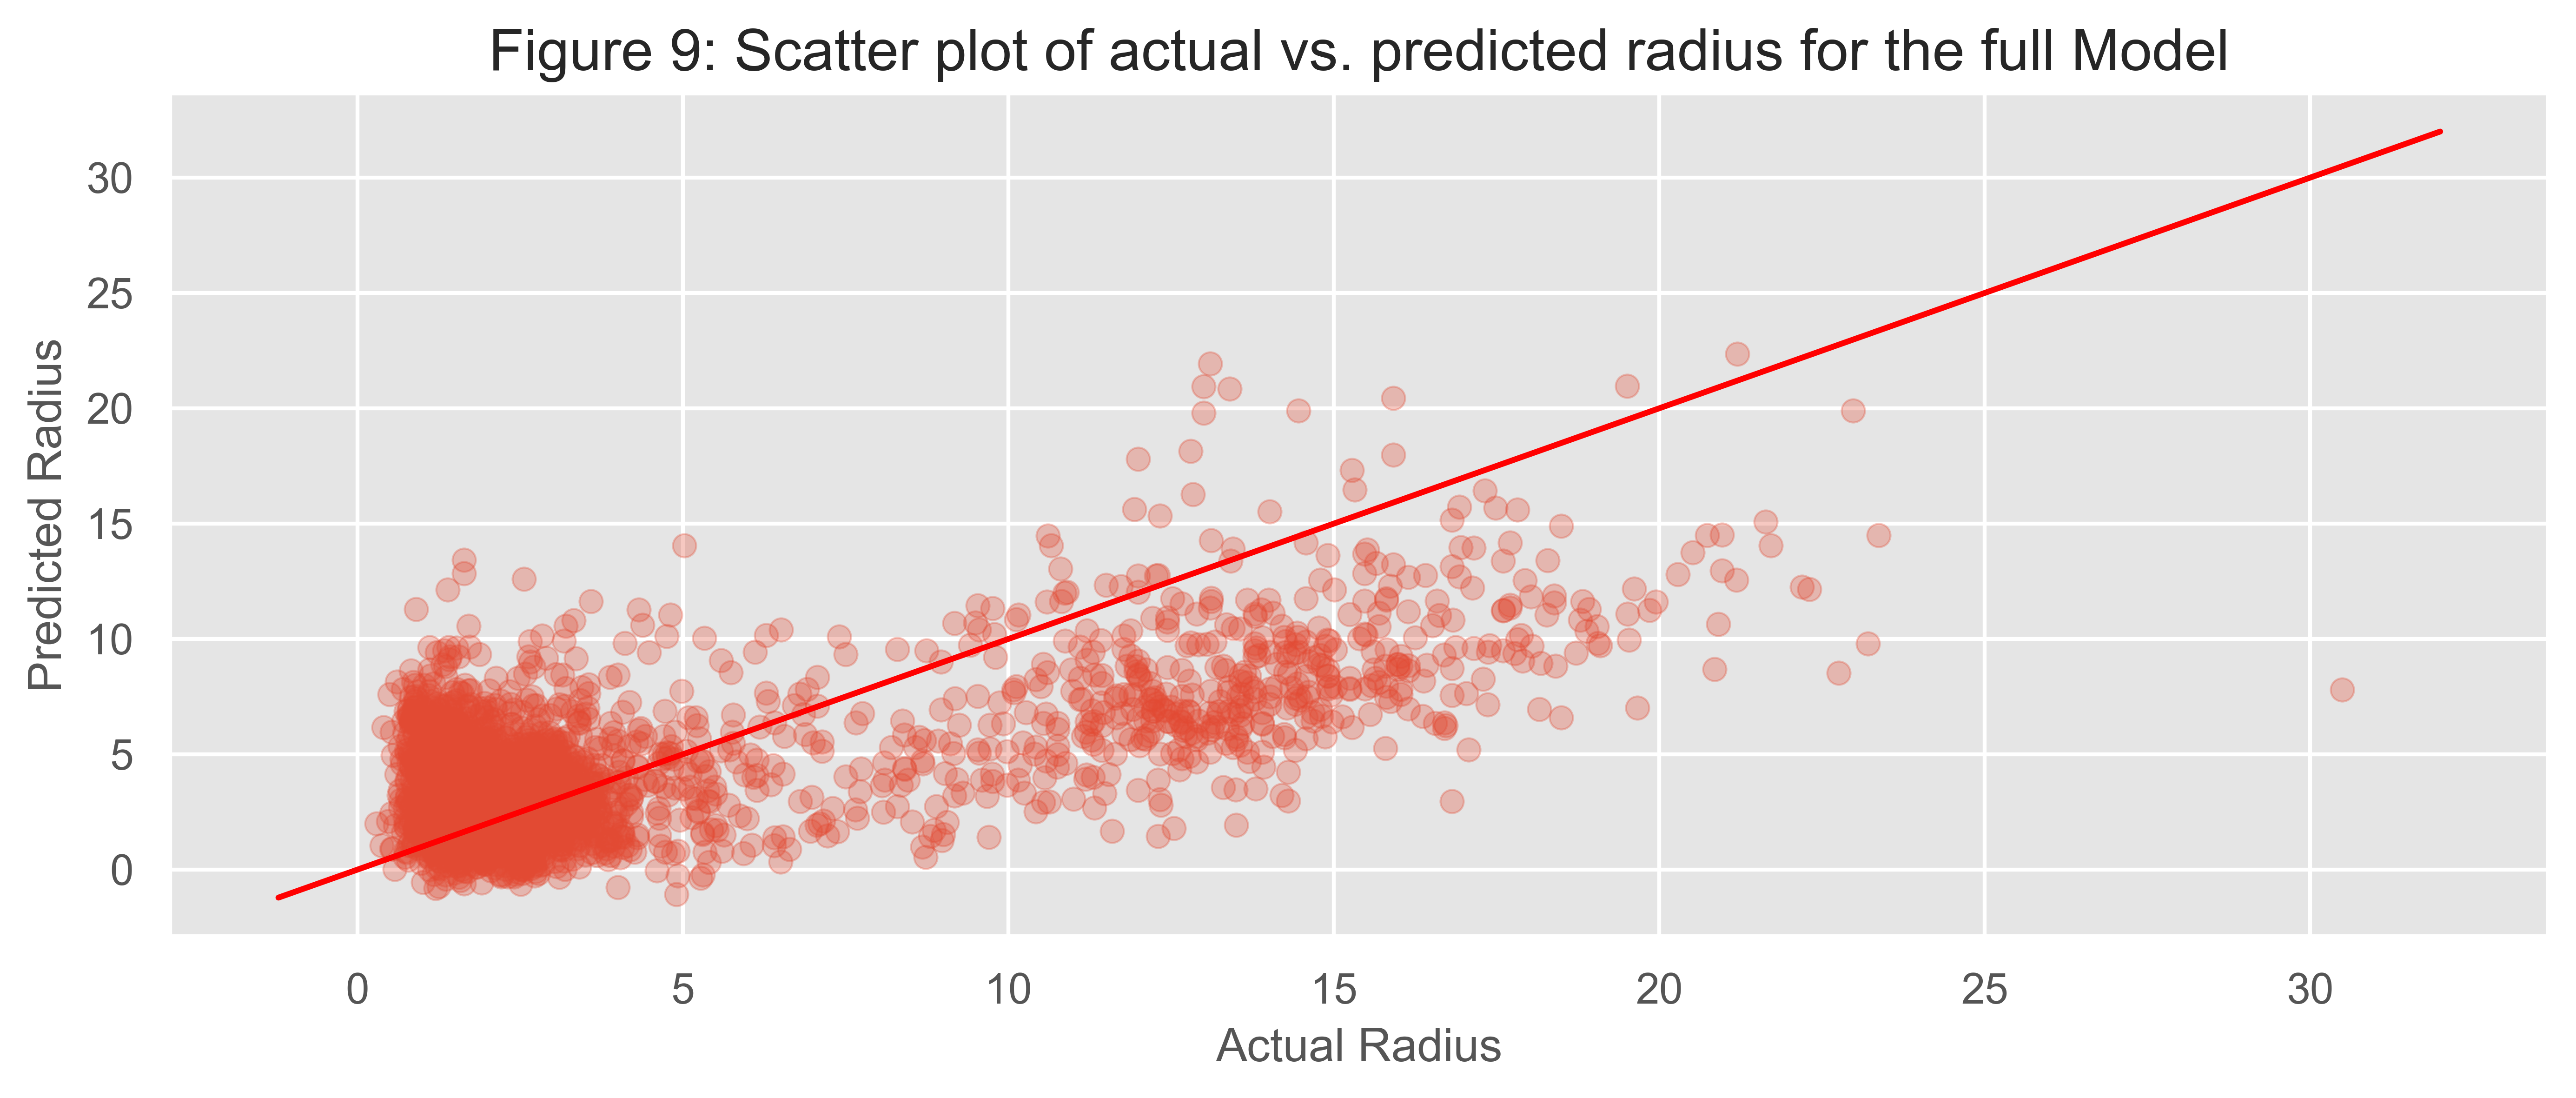

In [8]:
residuals_full = pd.DataFrame({'actual': df['planet_radius'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})
figure(figsize=(11, 4), dpi=300)
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Radius');
plt.ylabel('Predicted Radius');
plt.title('Figure 9: Scatter plot of actual vs. predicted radius for the full Model', fontsize=15);
plt.show();

#### Full Model Diagnostics Check

We would like to check whether there are indications of violations of the regression assumptions, which are:
1. Linearity of the relationship between target variable and the independent variables.
2. Constant variance of the errors.
3. Normality of the residual distribution.
4. Statistical independence of the residuals.

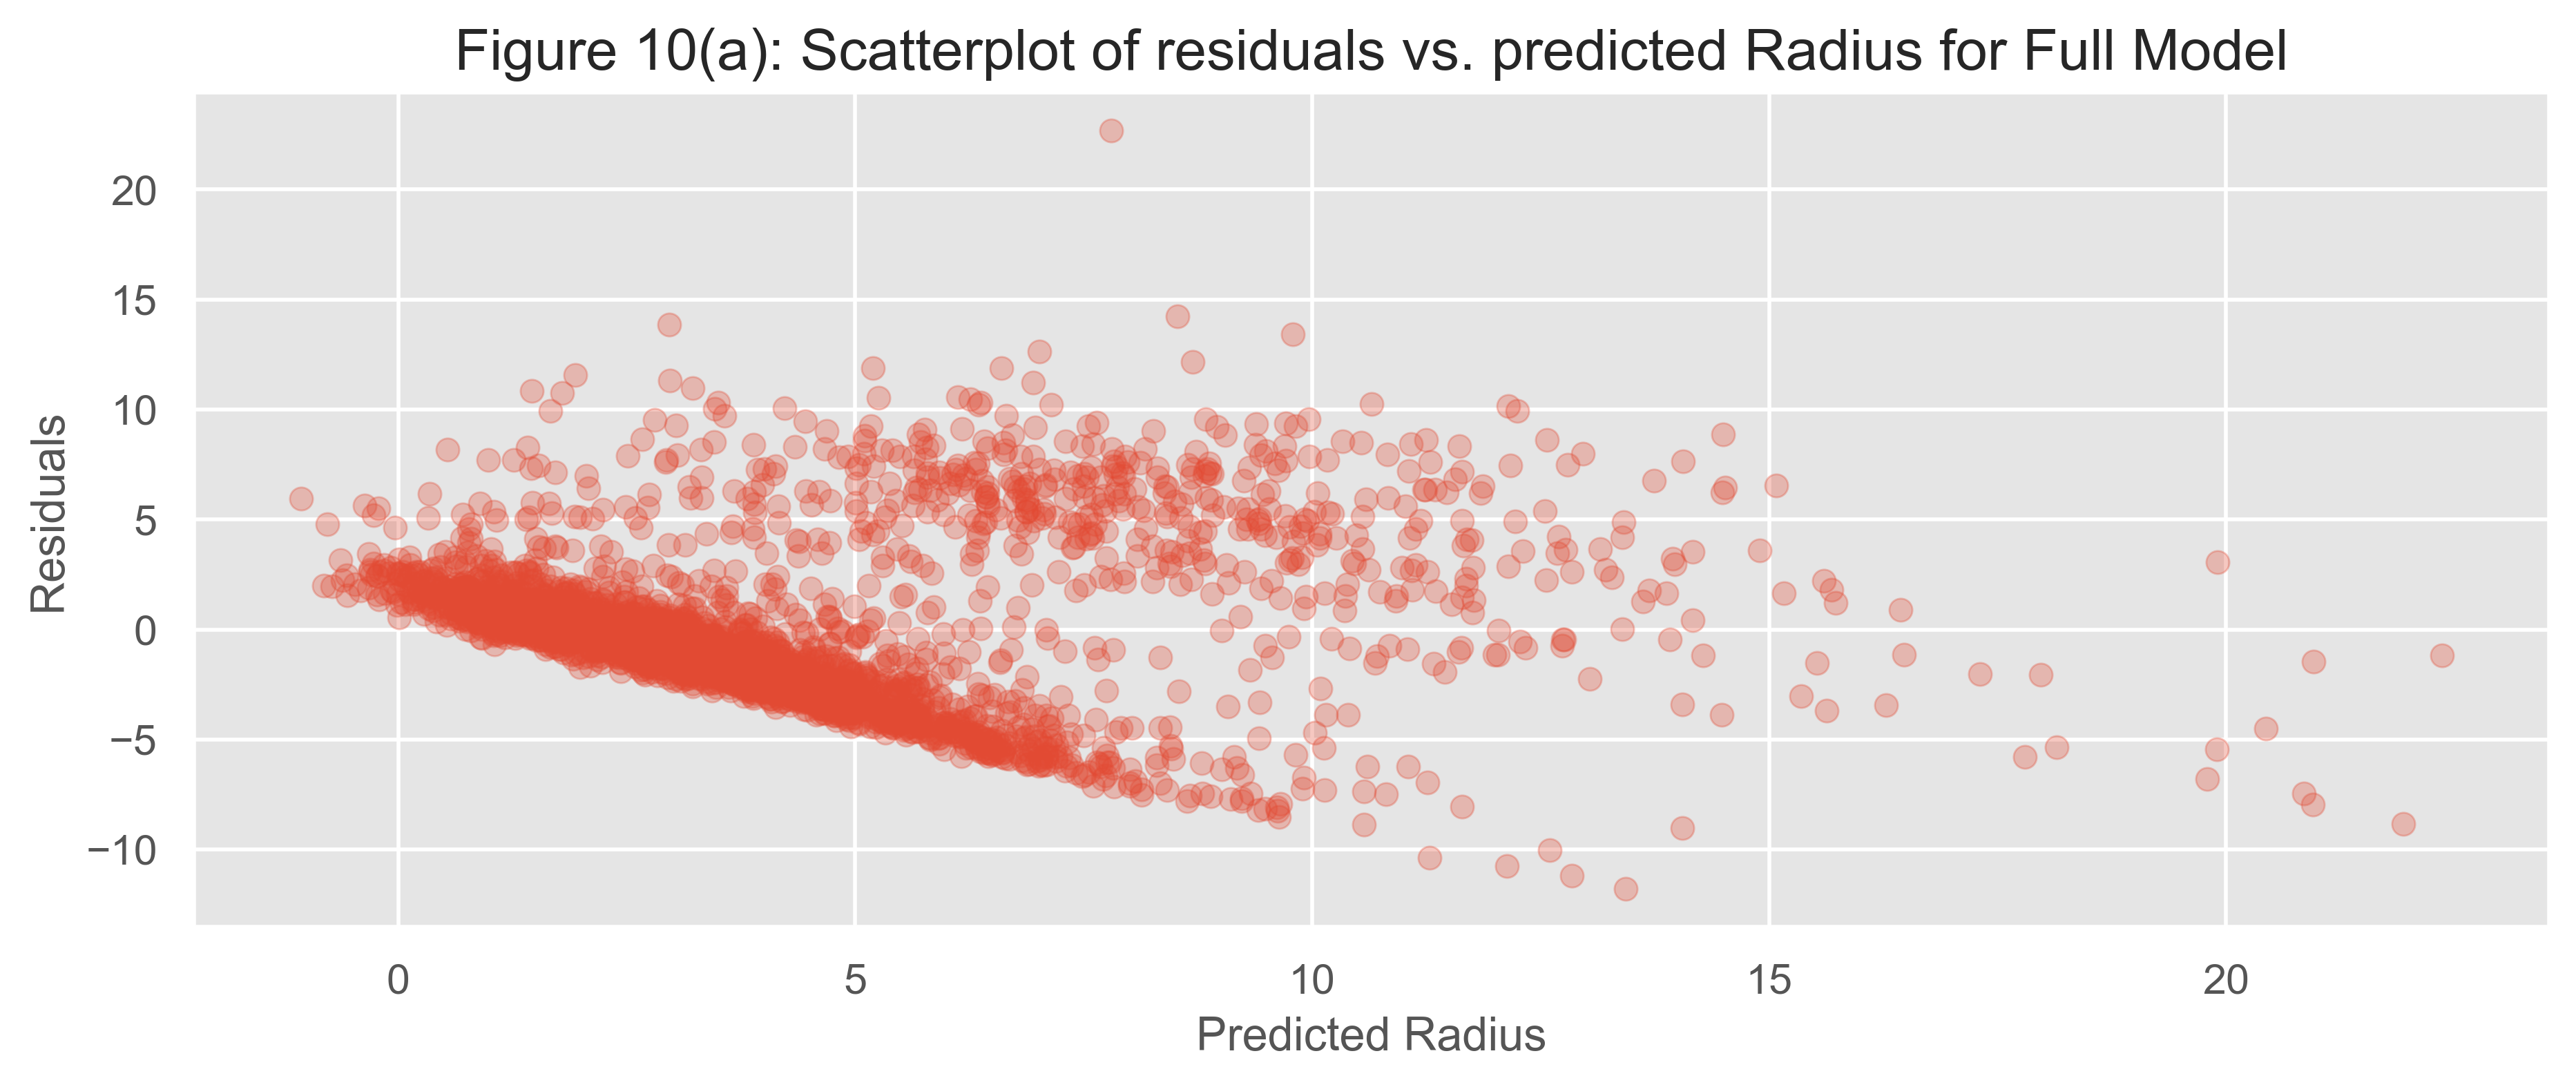

In [9]:
figure(figsize=(11, 4), dpi=200)
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Radius');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted Radius for Full Model', fontsize=15)
plt.show();

From this plot we see that the residuals exhibit a banding pattern, especially when Predicted Radius is below 10. The impact of the Keplar mission (as explored in Phase 1) can also be seen in this plot. The majority of datapoints which make up the left most hotspot seem to be over-estimated. Based on our previous exploration, we can assume that these data points are from the Keplar mission, which had higher success finding smaller, Earth-like exoplanets. 

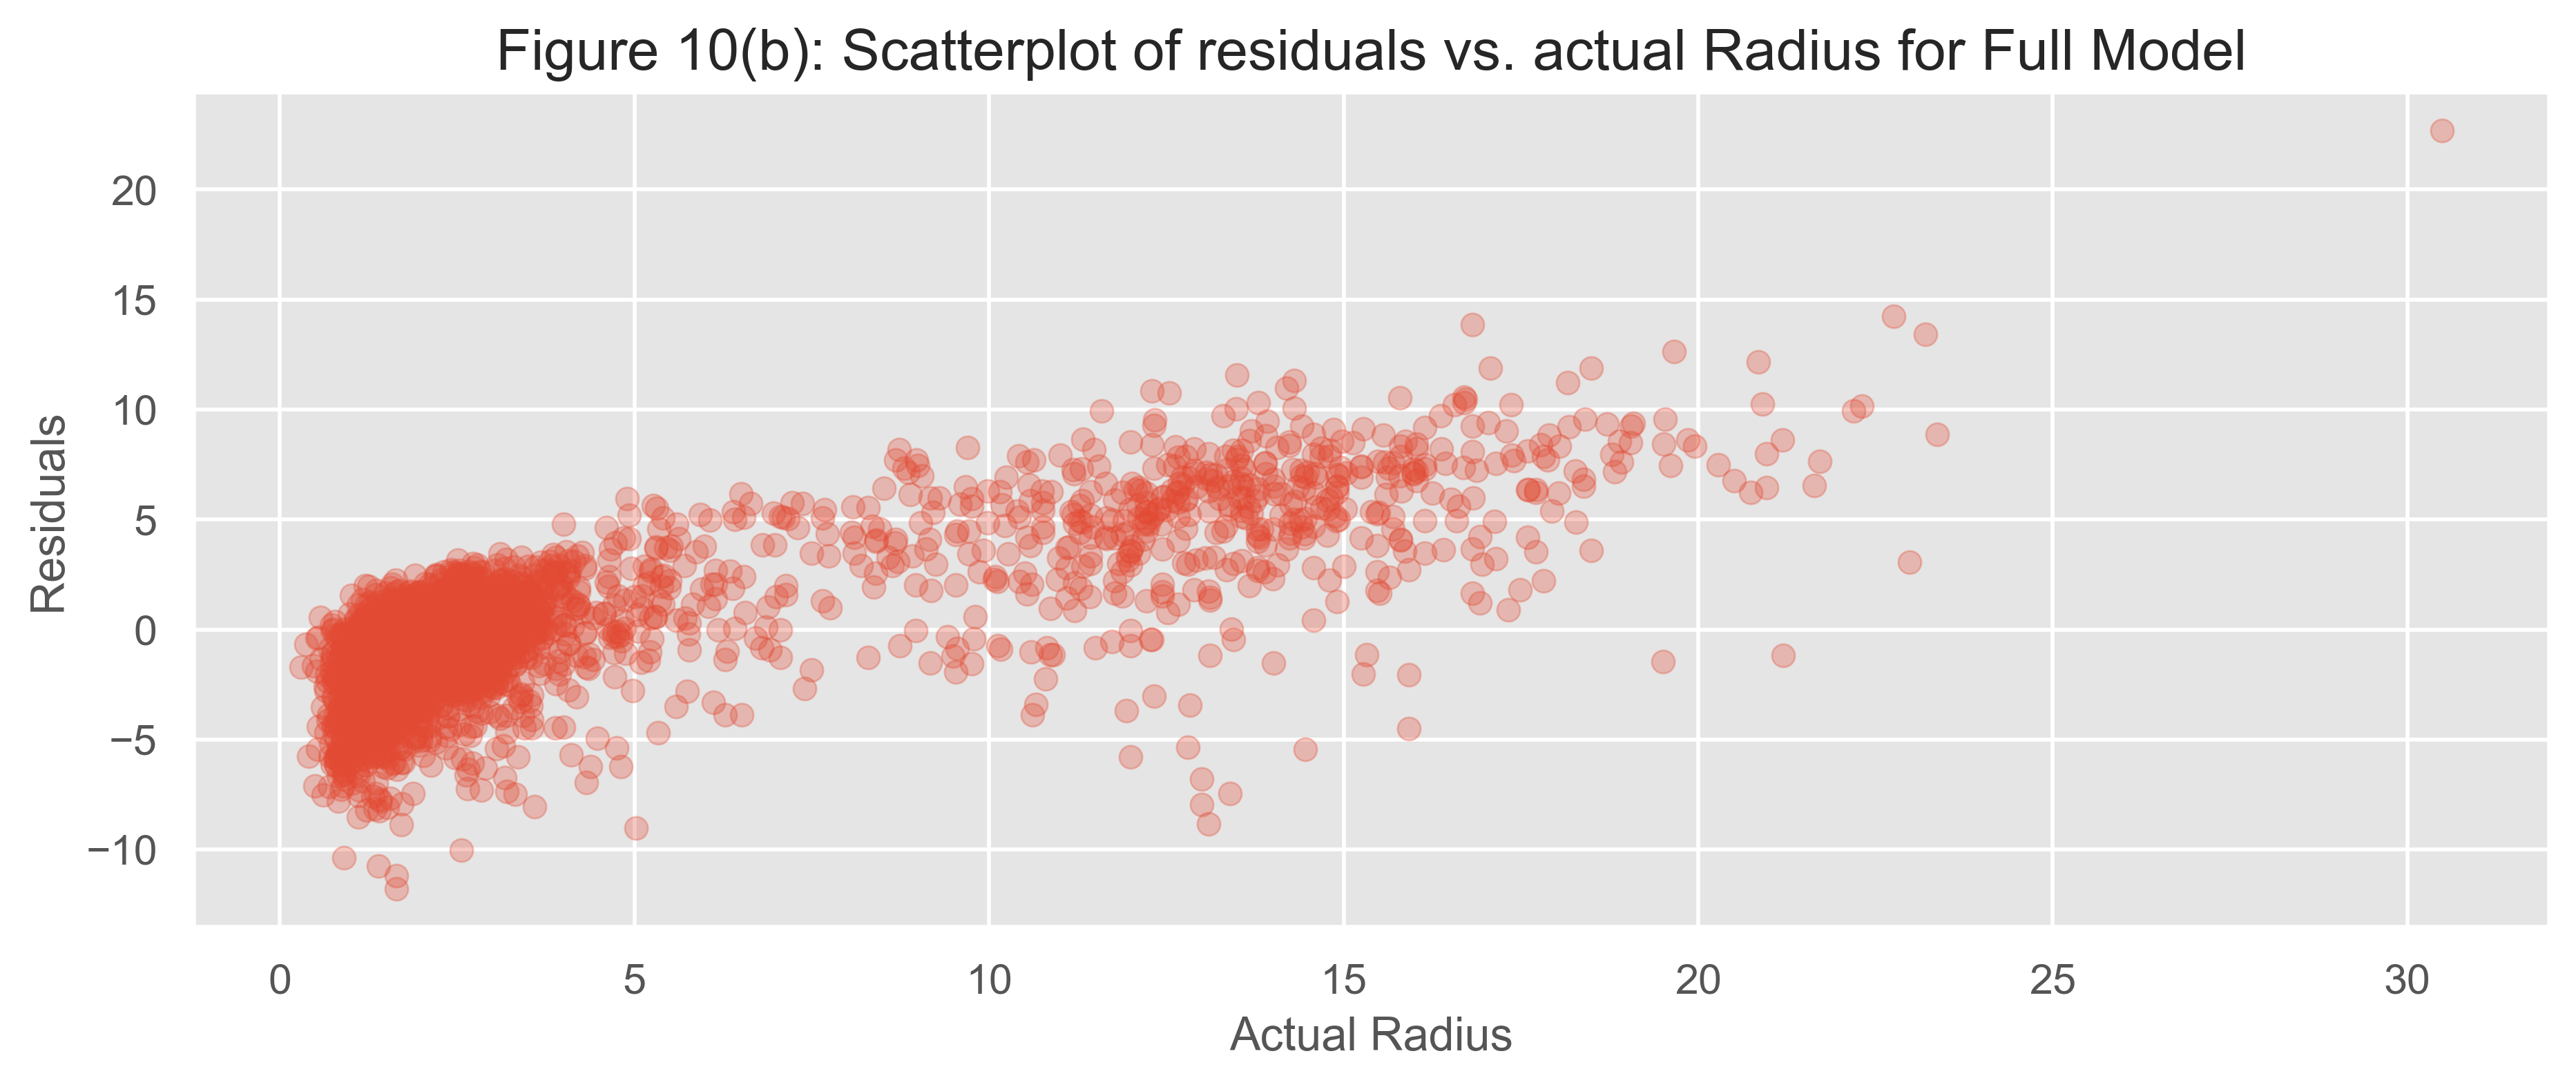

In [10]:
figure(figsize=(11, 4), dpi=200)
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Radius');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual Radius for Full Model', fontsize=15)
plt.show();

The shape of this plot shows that the model over-estimates the radius of small exoplanets.

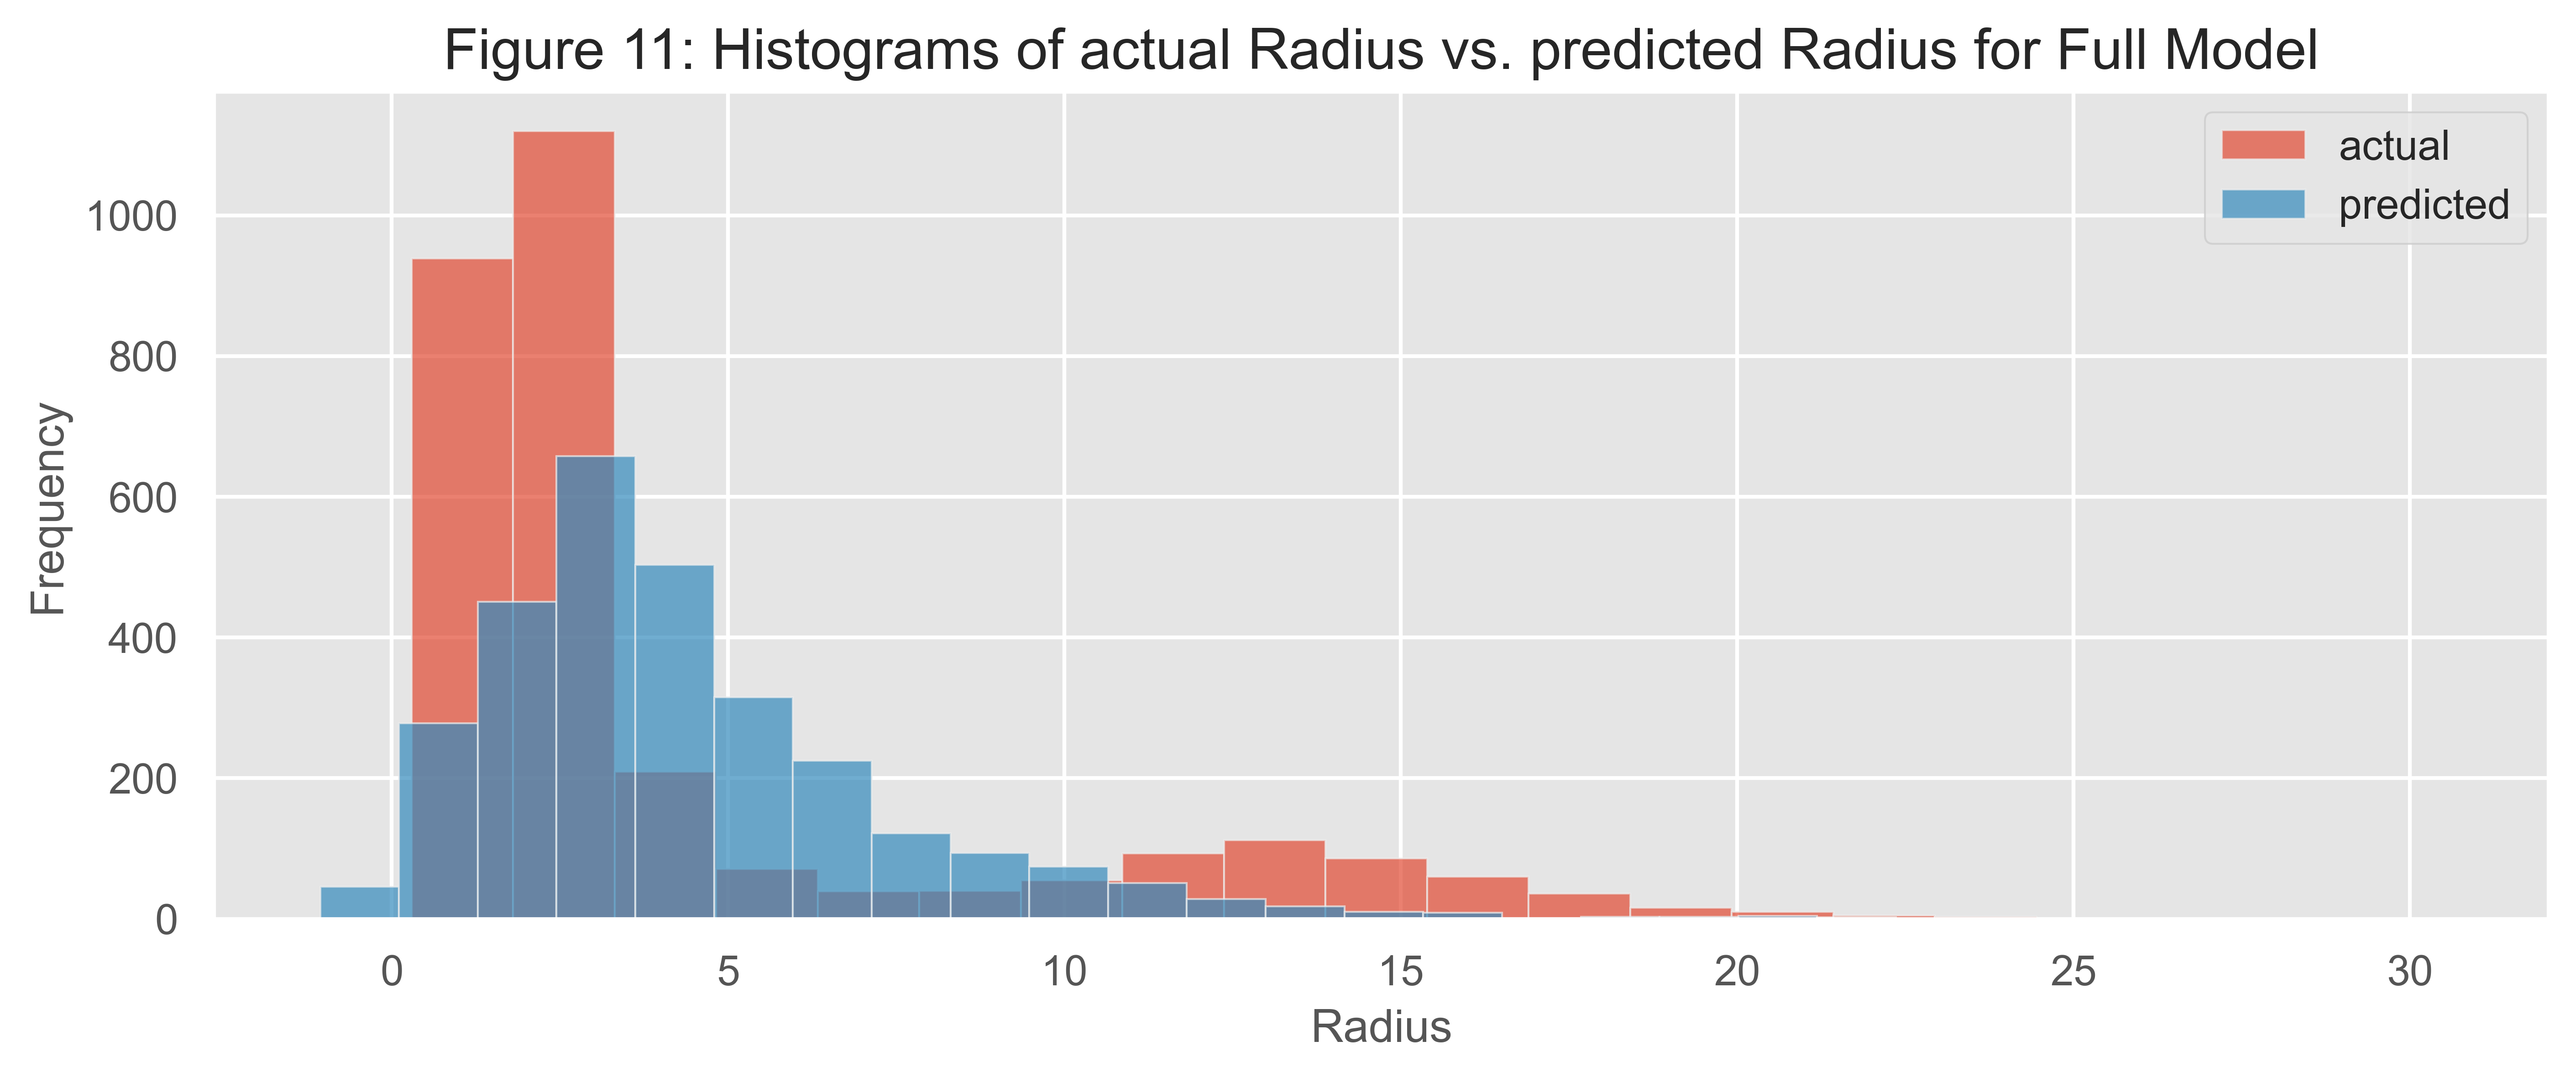

In [11]:
figure(figsize=(11, 4), dpi=300)
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Radius');
plt.ylabel('Frequency');
plt.title('Figure 11: Histograms of actual Radius vs. predicted Radius for Full Model', fontsize=15);
plt.legend()
plt.show();

Visible in this histogram is how our original dataset has two peaks, one from Keplar, and the right most peak from all other missions. Our model seems to pick the middle ground, which causes significant inaccuracy.

This violates the normality assumption for our residual distribution, which may cause our MLR model to be significantly weaker than expected.

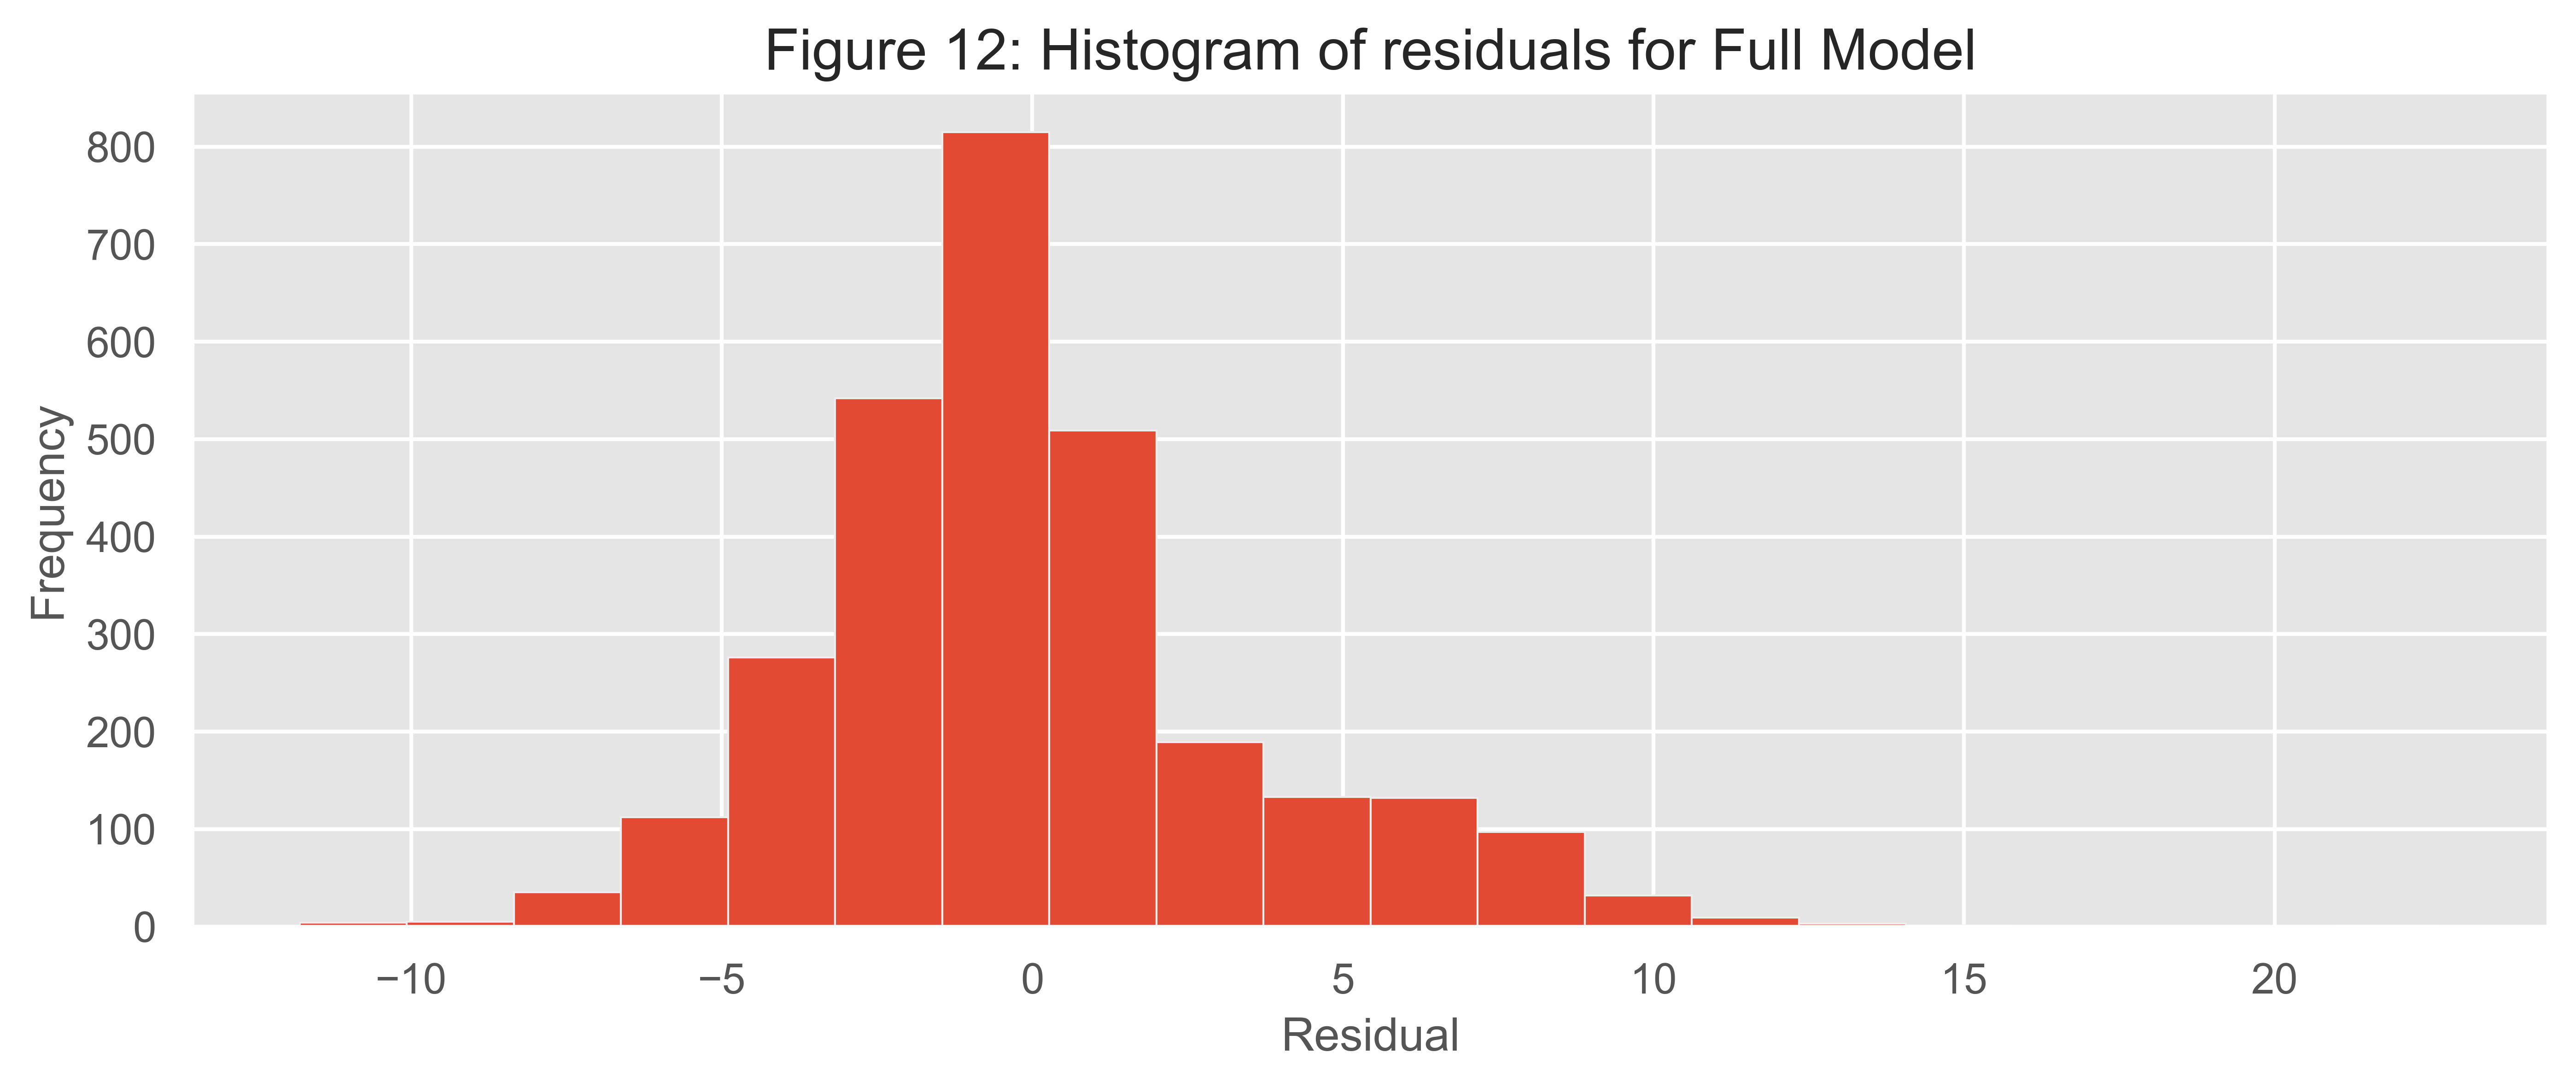

In [12]:
figure(figsize=(11, 4), dpi=300)
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

Performing backwards feature selection ([credit](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb)).

In [13]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')
to_remove = []
while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    # print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    to_remove.append(str(term))
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula=patsy_description, data=data_encoded).fit()
print("To remove list:", to_remove, "\n")
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "num_star_4" with p-value 0.9675

Removing term "num_star_3" with p-value 0.8402

Removing term "num_planet_2" with p-value 0.9379

Removing term "parallax" with p-value 0.6551

Removing term "num_planet_3" with p-value 0.6294

Removing term "num_star_2" with p-value 0.4447

Removing term "num_planet_7" with p-value 0.405

Removing term "num_planet_5" with p-value 0.3469

Removing term "num_planet_8" with p-value 0.2432

Removing term "two_stars" with p-value 0.2138

Removing term "num_planet_6" with p-value 0.07032
To remove list: ['num_star_4', 'num_star_3', 'num_planet_2', 'parallax', 'num_planet_3', 'num_star_2', 'num_planet_7', 'num_planet_5', 'num_planet_8', 'two_stars', 'num_planet_6'] 


***
                            OLS Regression Results                            
Dep. Variable:          planet_radius   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:       

#### Calculating Residuals for model visualization

In [14]:
residuals_reduced = pd.DataFrame({'actual': df['planet_radius'], 
                                  'predicted': model_reduced_fitted.fittedvalues, 
                                  'residual': model_reduced_fitted.resid})

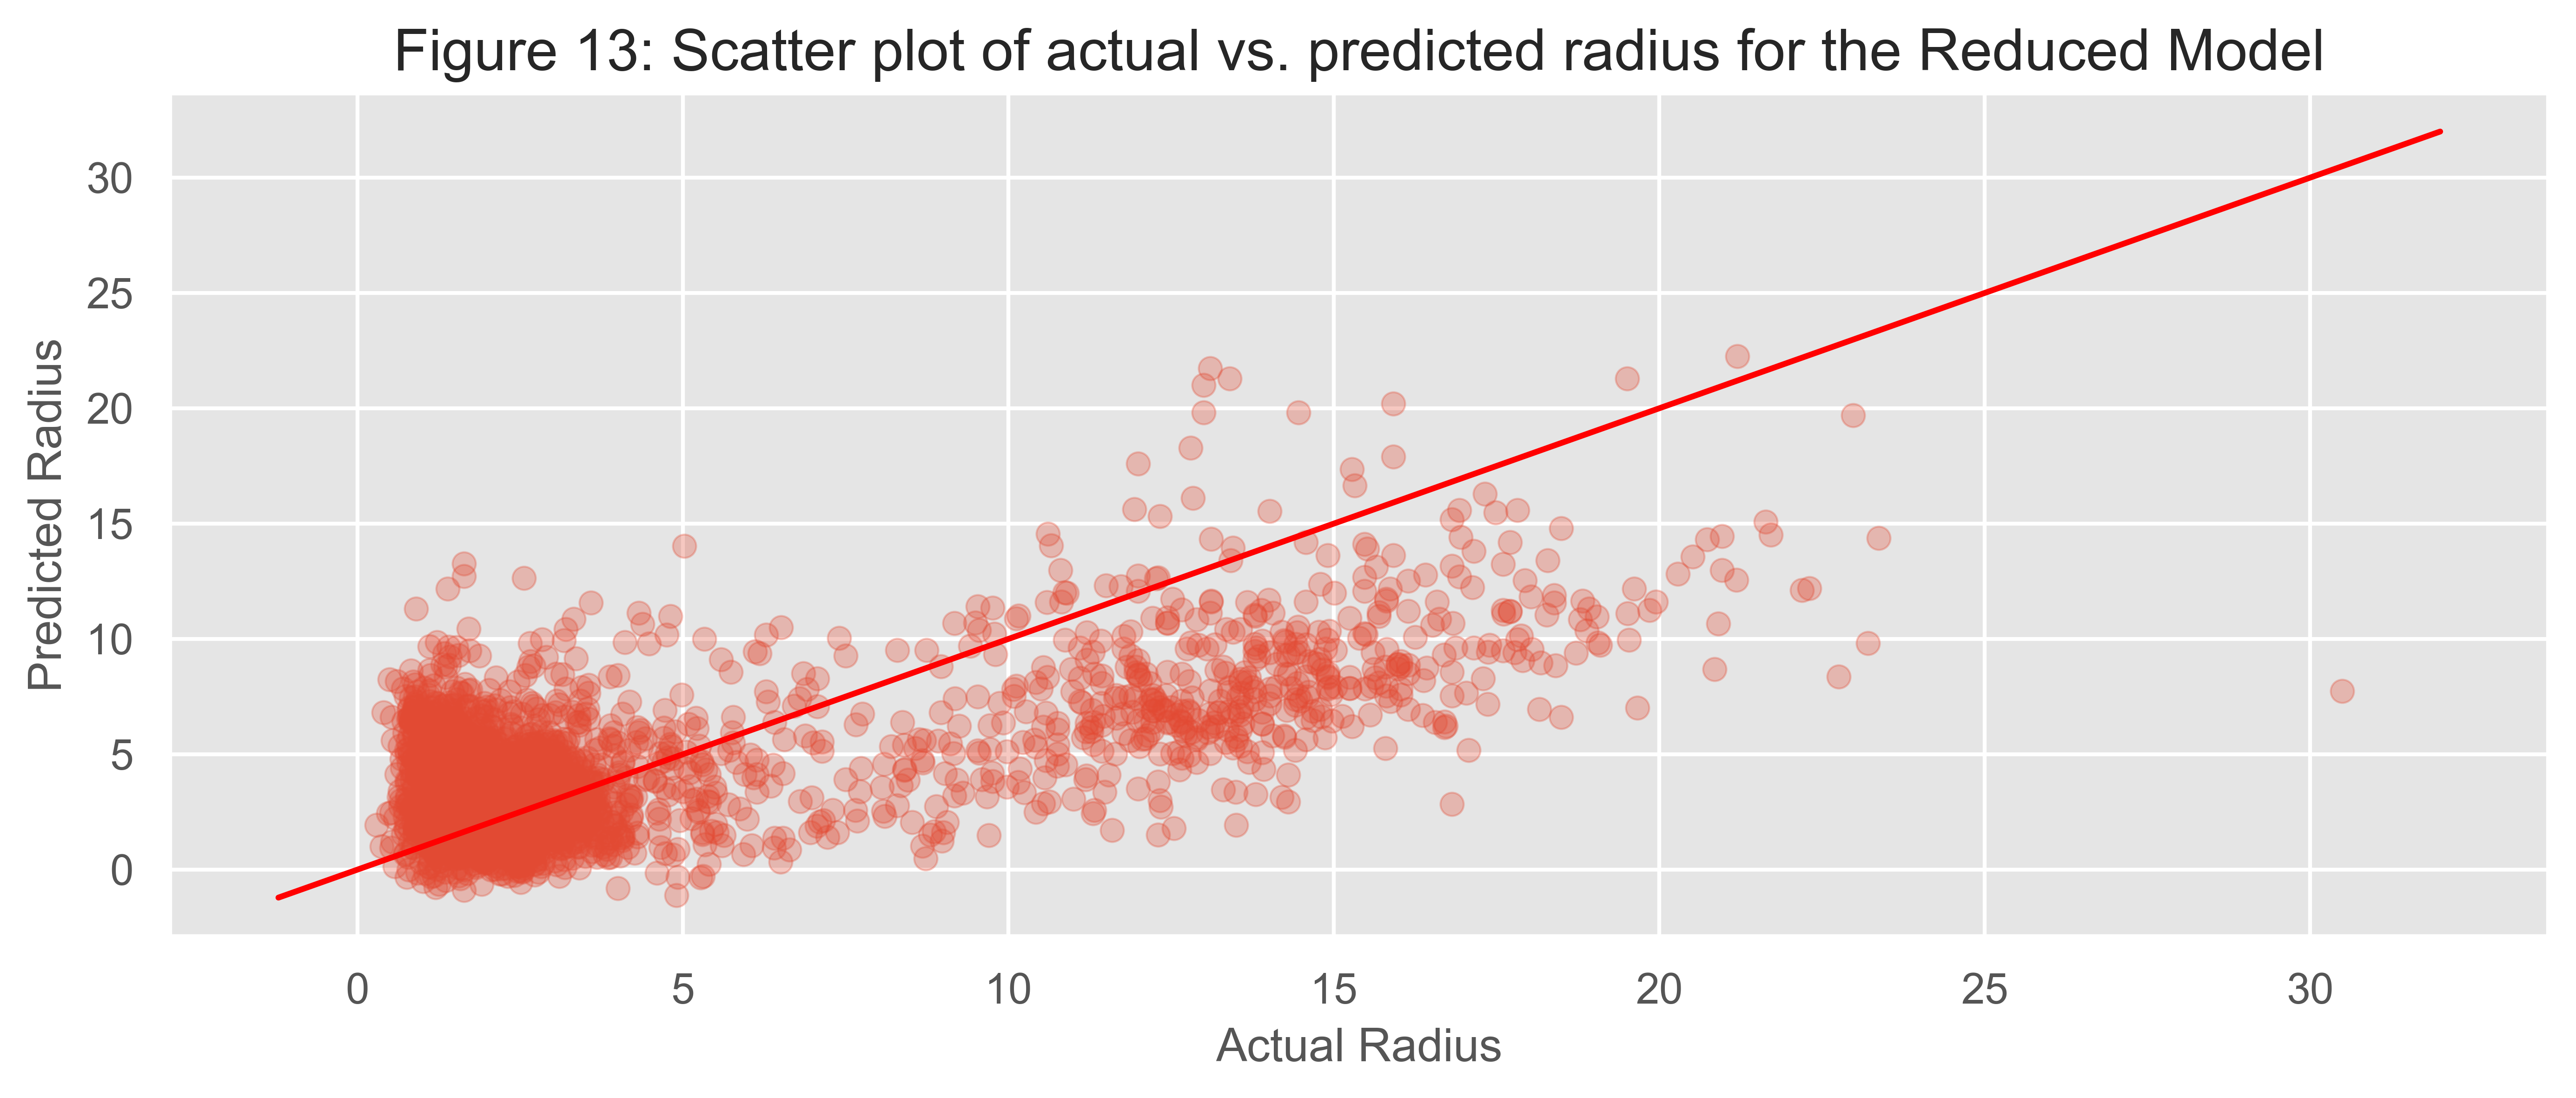

In [15]:
# Creating scatter plot for reduced model
figure(figsize=(11, 4), dpi=300)
plt.scatter(residuals_reduced['actual'], residuals_reduced['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Radius');
plt.ylabel('Predicted Radius');
plt.title('Figure 13: Scatter plot of actual vs. predicted radius for the Reduced Model', fontsize=15);
plt.show();

---

## Deep Neural Networks (DNN)

### Import Statements

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [17]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


### Data Reprocessing for DNN

To make our DNN more prcise, we will have to further control the amount of data that is passed through our neural network. This involves dropping features that do not contribute significantly to our target.
Please note that both the results for the MLR and DNN has been scaled equally to allow for a fair comparision. This would become obvious in the Fine Tuning Plots subchapter.

In [18]:
orig_data_dnn = df.copy()
categorical_vars = [ "num_star", "two_stars", "num_planet"]

for var in categorical_vars:
    orig_data_dnn = orig_data_dnn.astype({var: object})

# Categorical encoding for less than 2 values
for col in orig_data_dnn.columns:
    q = len(orig_data_dnn[col].unique())
    if (q == 2):
        orig_data_dnn[col] = pd.get_dummies(orig_data_dnn[col], drop_first=True)
# For categorical features > 2 levels
orig_data_dnn = pd.get_dummies(orig_data_dnn)

print(f"There are {orig_data_dnn.shape[1]} columns with the column names {orig_data_dnn.columns.to_list()} after one hot encoding")
orig_data_dnn.shape

There are 25 columns with the column names ['two_stars', 'orbital_period', 'semi_major_axis', 'planet_radius', 'planet_eccen', 'planet_temp', 'star_temp', 'star_radius', 'star_mass', 'star_bright', 'star_age', 'distance', 'parallax', 'num_star_1', 'num_star_2', 'num_star_3', 'num_star_4', 'num_planet_1', 'num_planet_2', 'num_planet_3', 'num_planet_4', 'num_planet_5', 'num_planet_6', 'num_planet_7', 'num_planet_8'] after one hot encoding


(2895, 25)

### Outlier Processing for DNN

Conversely to our intial beliefs, the DNN failed to perform approapiately when we filtered out outliers. At some cases, our NN performed so terribly it would be almost impossible to graph it. This is predominantly due to the oulier check getting rid of **two thirds** of our dataset, and only leaving highly biased data from the Keplar Mission. The lack of variety, far too many columns, and a much smaller dataset led to our NN making constant, obvious (and boring) predictions. To tackle our outliers, we chose to use an outlier friendly optimizer, which will be further expanded in the literature.

In [19]:
# # Outlier filter
# def set_outlier_nan(df):
#     """
#     - Finds outliers and sets their values to NaN to be processed later.
#     - Excluded columns involves categories to be excluded from the outlier check
#     """
# #     excluded_columns = [
# #                         'num_star',
# #                         'num_planet',
# #                         'two_stars',
# #                         'longitude_gal',
# #                         'latitude_gal',
# #                         'parallax',
# #                         'distance',
# #     ]
#     for column_name in df.columns: 
#     # conditional to exclude certain columns from the outlier check
# #     if column_name in excluded_columns:
# #         continue
# #     else:
#         column = df[column_name]
#         q1 = column.quantile(0.25)
#         q3 = column.quantile(0.75)
#         iqr = column.quantile(0.75) - column.quantile(0.25)

#         lower = q1 - 3 * iqr
#         upper = q3 + 3 * iqr
#         num_column_outliers = df[(column > upper) | (column < lower)]\
#         .shape[0]
#         # set rows that exceeds outlier parameters to none
#         df[(column > upper) | (column < lower)] = np.nan

#     return df

# orig_data_dnn = set_outlier_nan(df=orig_data_dnn)
# print(
# f"""
# The outlier check will get rid of {orig_data_dnn["planet_radius"].isna().sum()} planets.
# """)
# orig_data_dnn = orig_data_dnn.dropna()
# print(f"The dataset now has {orig_data_dnn.shape[0]} planets")

### Apply Feature Selection and Column Processing for DNN

The following code reduces the number of unnecessary columns both by feature selection (of p values) and manual selection, to make our NN far more accurate.

In [20]:
data_dnn = orig_data_dnn.copy()
target_df = data_dnn['planet_radius'].values.reshape(-1, 1)
target_norm = MinMaxScaler().fit_transform(target_df)

data_dnn.loc[:, 
        ['planet_radius']
                ] = pd.DataFrame(target_norm, columns=['planet_radius'])

# Apply feature selection
for col_name in to_remove:
    data_dnn.drop(col_name, axis=1, inplace=True)

# Remove unecessary columns to increase precision
unnecessary_cols = [
    'semi_major_axis',
    'planet_eccen',
    'star_mass',
    'star_bright',
    'num_star_1',
    'num_planet_1',
    'num_planet_4',
]
for col_name in unnecessary_cols:
    data_dnn.drop(col_name, axis=1, inplace=True)

data_dnn.sample(3)

orbital_period  planet_radius  planet_temp  star_temp  star_radius  \
948        42.882000       0.133280        709.0     6022.0         1.85   
1193        6.651380       0.078299       1095.0     5355.0         0.84   
448         2.414352       0.022655        953.0     4529.0         0.69   

      star_age  distance  
948       3.24   566.850  
1193      4.47   413.873  
448       3.09   151.129

### Data Partition

Partition the dataset into both training and testing datasets.

In [21]:
train_dataset = data_dnn.sample(frac=0.8, random_state=0)
test_dataset = data_dnn.drop(train_dataset.index)
print(
f"""
--- Dataset Sizes ---
Original Dataset: {data_encoded.shape}
Training Dataset: {train_dataset.shape}
Testing Dataset: {test_dataset.shape}
"""
)



--- Dataset Sizes ---
Original Dataset: (2895, 25)
Training Dataset: (2316, 7)
Testing Dataset: (579, 7)



In [22]:
train_dataset.describe().transpose()

count         mean          std          min          25%  \
orbital_period  2316.0    96.845960  1781.304729     0.280324     3.965398   
planet_radius   2316.0     0.133587     0.153514     0.000000     0.042859   
planet_temp     2316.0   925.511658   454.383865   125.000000   580.750000   
star_temp       2316.0  5515.322936   707.367629  2566.000000  5190.750000   
star_radius     2316.0     1.040203     0.414777     0.010000     0.810000   
star_age        2316.0     4.194171     2.752552     0.012000     2.600000   
distance        2316.0   706.413402   479.209174     3.290000   342.143000   

                        50%          75%           max  
orbital_period     9.112331    21.405835  69000.000000  
planet_radius      0.069687     0.118790      0.764275  
planet_temp      836.500000  1170.250000   3186.000000  
star_temp       5653.000000  5961.250000   9360.000000  
star_radius        0.960000     1.210000      6.300000  
star_age           3.890000     4.802500     14.000000  
distance         641.327500   969.418500   4483.050000

### Target Feature Partition

In [23]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('planet_radius')
test_labels = test_features.pop('planet_radius')

In [24]:
train_dataset.describe().transpose()[['mean', 'std']]

mean          std
orbital_period    96.845960  1781.304729
planet_radius      0.133587     0.153514
planet_temp      925.511658   454.383865
star_temp       5515.322936   707.367629
star_radius        1.040203     0.414777
star_age           4.194171     2.752552
distance         706.413402   479.209174

### Data Normalisation

In [25]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[  96.846  925.512 5515.323    1.04     4.194  706.413]]


In [26]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   3.48 1156.   5418.      0.93    8.71  450.  ]]

Normalized: [[-0.05  0.51 -0.14 -0.27  1.64 -0.54]]


### Plotting Functions

Functions for plotting graphs later on.

In [27]:
def plot_loss(history):
    figure(figsize=(15, 4), dpi=150)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("Fig. 14: Loss Analysis")
    plt.xlabel('Epoch')
    plt.ylabel('Error [Planet Radius]')
    plt.legend()
    plt.grid(True)
    
def plot_history(history): 
    figure(figsize=(15, 4), dpi=150)
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('Fig. 15: Mean Squared Error over Epoch')
    plt.ylabel('Mean Squared Error [Planet Radius]')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

### DNN Model Build and Compilation

Builds and compiles the model structure.  Further discussed in literature.

In [28]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(24, activation='relu', name='layer1'),
        layers.Dropout(0.015),
        layers.Dense(24, activation='relu', name='layer2'),
        layers.Dropout(0.00),
        layers.Dense(1, activation='linear', name='output_layer')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007)
#     optimizer = tf.keras.optimizers.SGD(learning_rate=10e-4, decay=1e-6, momentum=0.5)
    # For loss justification: https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
    model.compile(loss='mean_absolute_error',
                 optimizer=optimizer,
                 # https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [29]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
layer1 (Dense)               (None, 24)                168       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
layer2 (Dense)               (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 25        
Total params: 806
Trainable params: 793
Non-trainable params: 13
_________________________________________________________

### DNN Model Training

Train the model based off the training data. Further discussed in literature.

In [30]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=150)

Wall time: 20.9 s


### Fine Tuning Plots

Key plots that denotes model performance, which is than used to fine tune our network. Even though this process will be discussed upon in our literature, small summaries underneath each graph will highlight the intentions behind every plot.

#### Loss Analysis

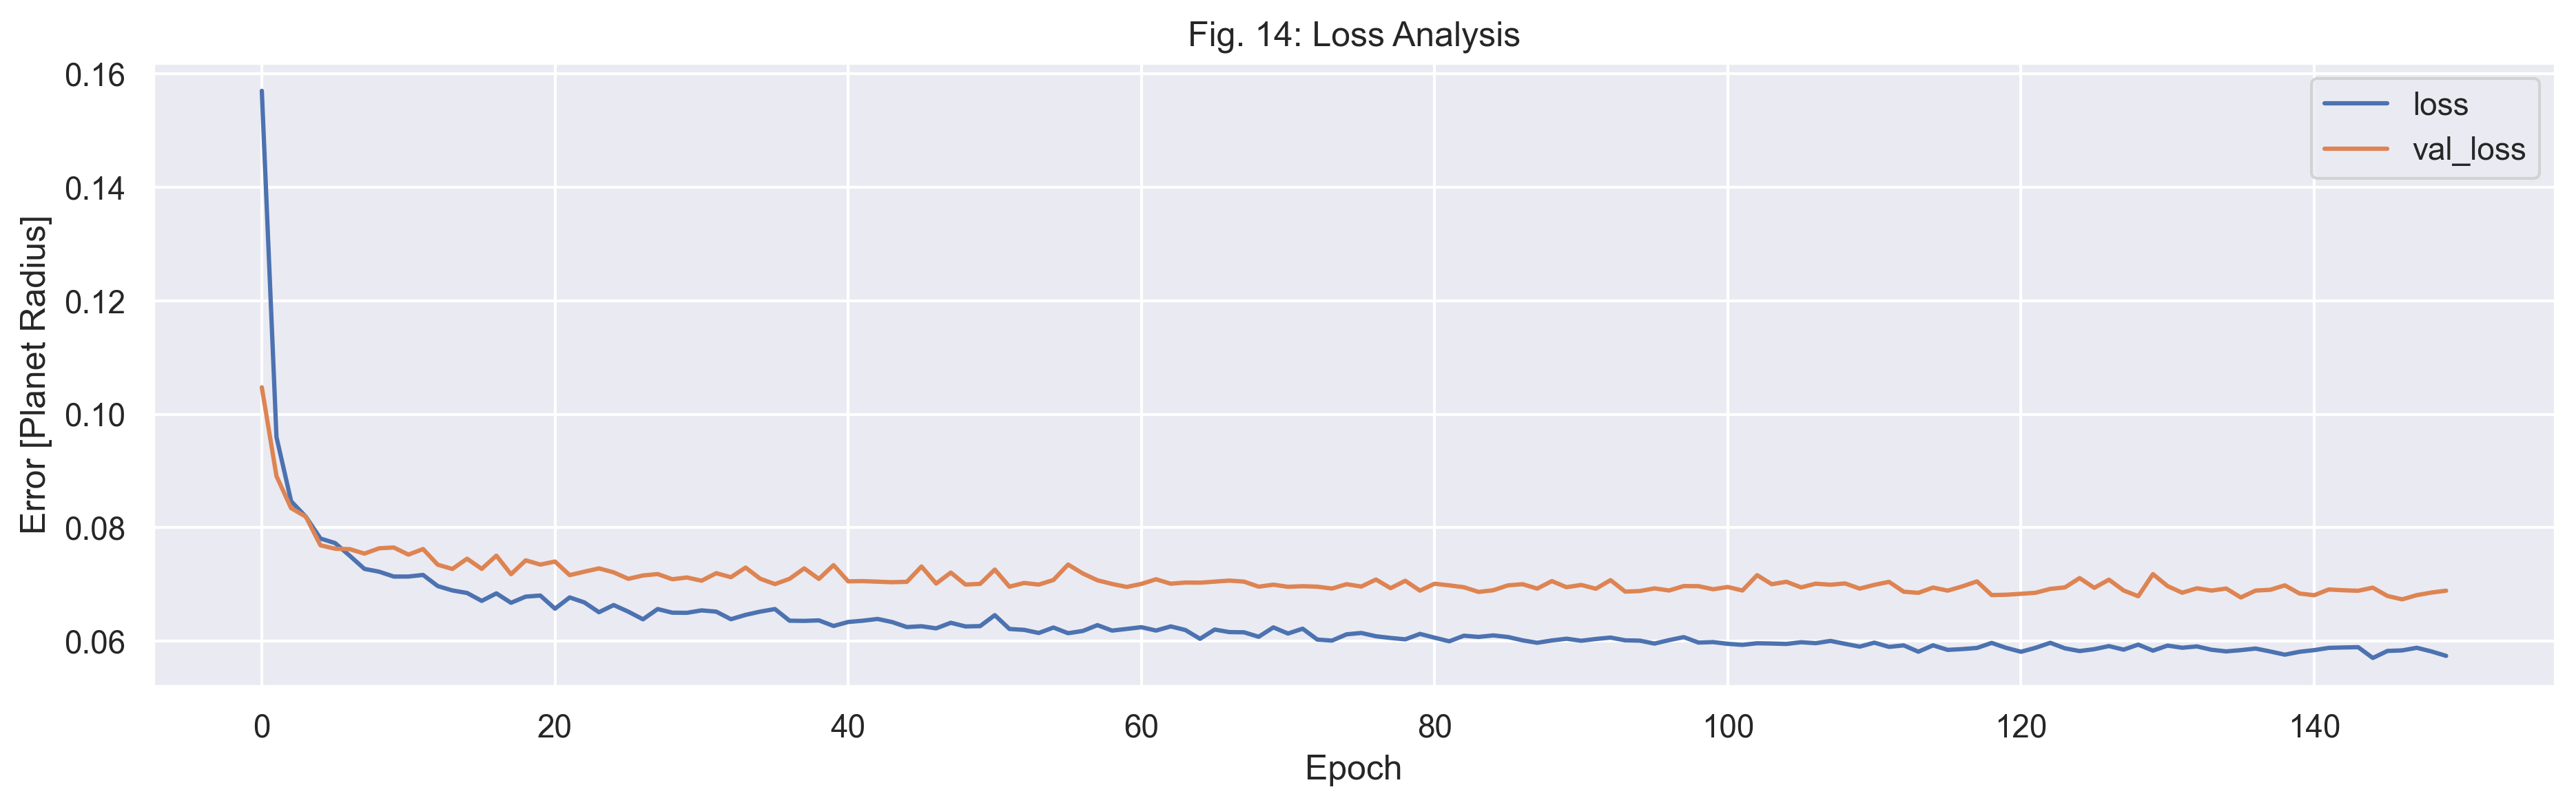

In [40]:
plot_loss(history)

Figure 14 demonstrates the loss anlaysis graph for our current dnn. The graph shows error prediction of our target feature, planet radius, as the network gradually learns (over epoch). As a result, loss analysis is key to determining the overall learning performance of a neural network. 
To elaborate further, loss is the value the neural network is trying to minimize over time, a lower loss value is indicative of more accurate predictions. Consequntly, the dnn learns by readjusting tis node's weights and biases in a manner which reduces the loss.
Val Loss is applied to the test set, and is a good indication of how the network will perform with data it has never seen before. (https://stackoverflow.com/questions/47299624/how-to-understand-loss-acc-val-loss-val-acc-in-keras-model-fitting)

Our loss analysis graph indicates a good learning progress for our dnn. Firstly, both loss values takes the shape of an inverse logarthmic, which demonstartes a great learning performance as our epoch progresses. Secondly, the error values for both curves can be considered to be quite low (in terms of astronomical predictions), highlighting high accuracy when predicting our target feature. Finally, our loss and val_loss curves are very tightly packed together. This illustrates our dnn *learning* the data approapiately, rather than just memorising the training data, or failing to see any connections within the dataset. Despite such positives, there does seem to be a minor issue of the curves becoming quite jaggered, indicating a lack of confidence in our dnn prdeictions. This, however, may be a limitation of the dataset we are working on (see the discussion subchapter to understand how this was reduced).

Overall, fig 14. displays the great learning progress of our dnn as epoch progresses. However, the curves do come out as **slightly** jaggered, which may show our dnn strugling to learn at certain stages.

#### MSE per Epoch

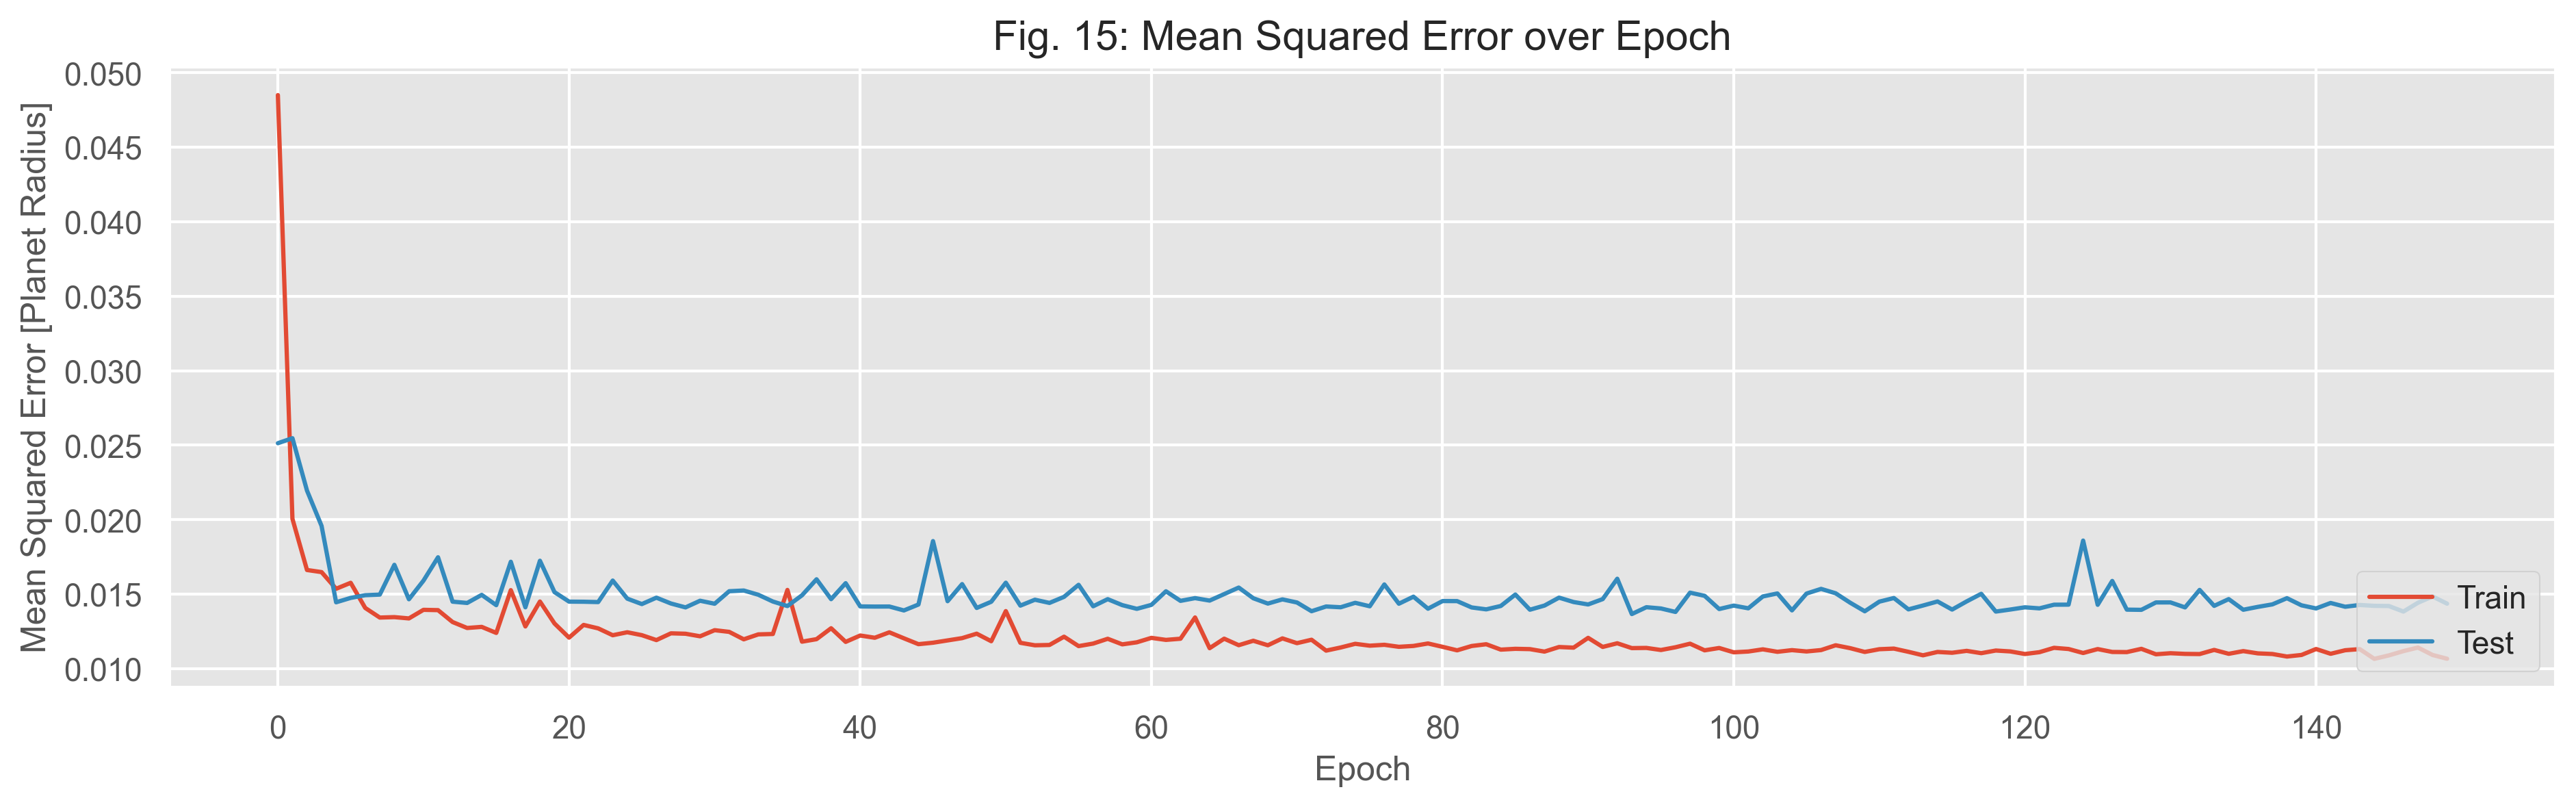

In [32]:
plot_history(history)

Figure 15 denotes the mean squared error (mse) as epoch increases for our dnn. "MSE is an absolute measure of how well the model fits" (https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b), and is denoted by the following formula:

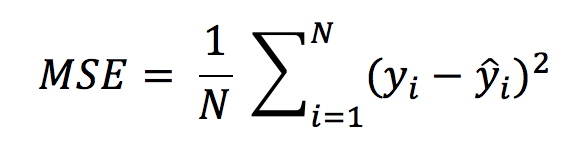

Given so, fig. 15 heavily takes on the shape of fig. 14, confirming the great dnn performance over both train and test data. In analysis, our mse graph signifies a very high accuracy rate for our current dnn model. The low mse values is indicative of how little the predicted results (in both training and test) deviate form the actual number. However, the *slightly* jaggered curves do highlight our model struggling to learn at certain cases (as mentioned previously). Again, this is likely to be a limitation of the dataset that was used.

#### Data Output

Output MSE data.

In [33]:
# Gather Results and Predict data via neural network
test_results = pd.DataFrame([])
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

19/19 [==============================] - 0s 2ms/step - loss: 0.0632 - mean_squared_error: 0.0130


#### DNN Model Prediction

Create a prediction based off our test data.

In [34]:
test_predictions = dnn_model.predict(test_features).flatten()

#### Same Scale Normalisation for MLR Results

Normalise MLR data to the same scale so accurate comaprisions may be made.

In [35]:
# Normalise the residuals_reduced df results between 0 and 1 for performance analysis.
# mlr_error_reshaped = residual.values.reshape(-1, 1)
residuals_reduced_norm = pd.DataFrame(MinMaxScaler().fit_transform(residuals_reduced), columns=residuals_reduced.columns)
residuals_reduced_norm.sample(3)

actual  predicted  residual
209   0.103140   0.315324  0.255346
1492  0.095191   0.087692  0.403022
529   0.083267   0.217157  0.304588

#### Key Statistics

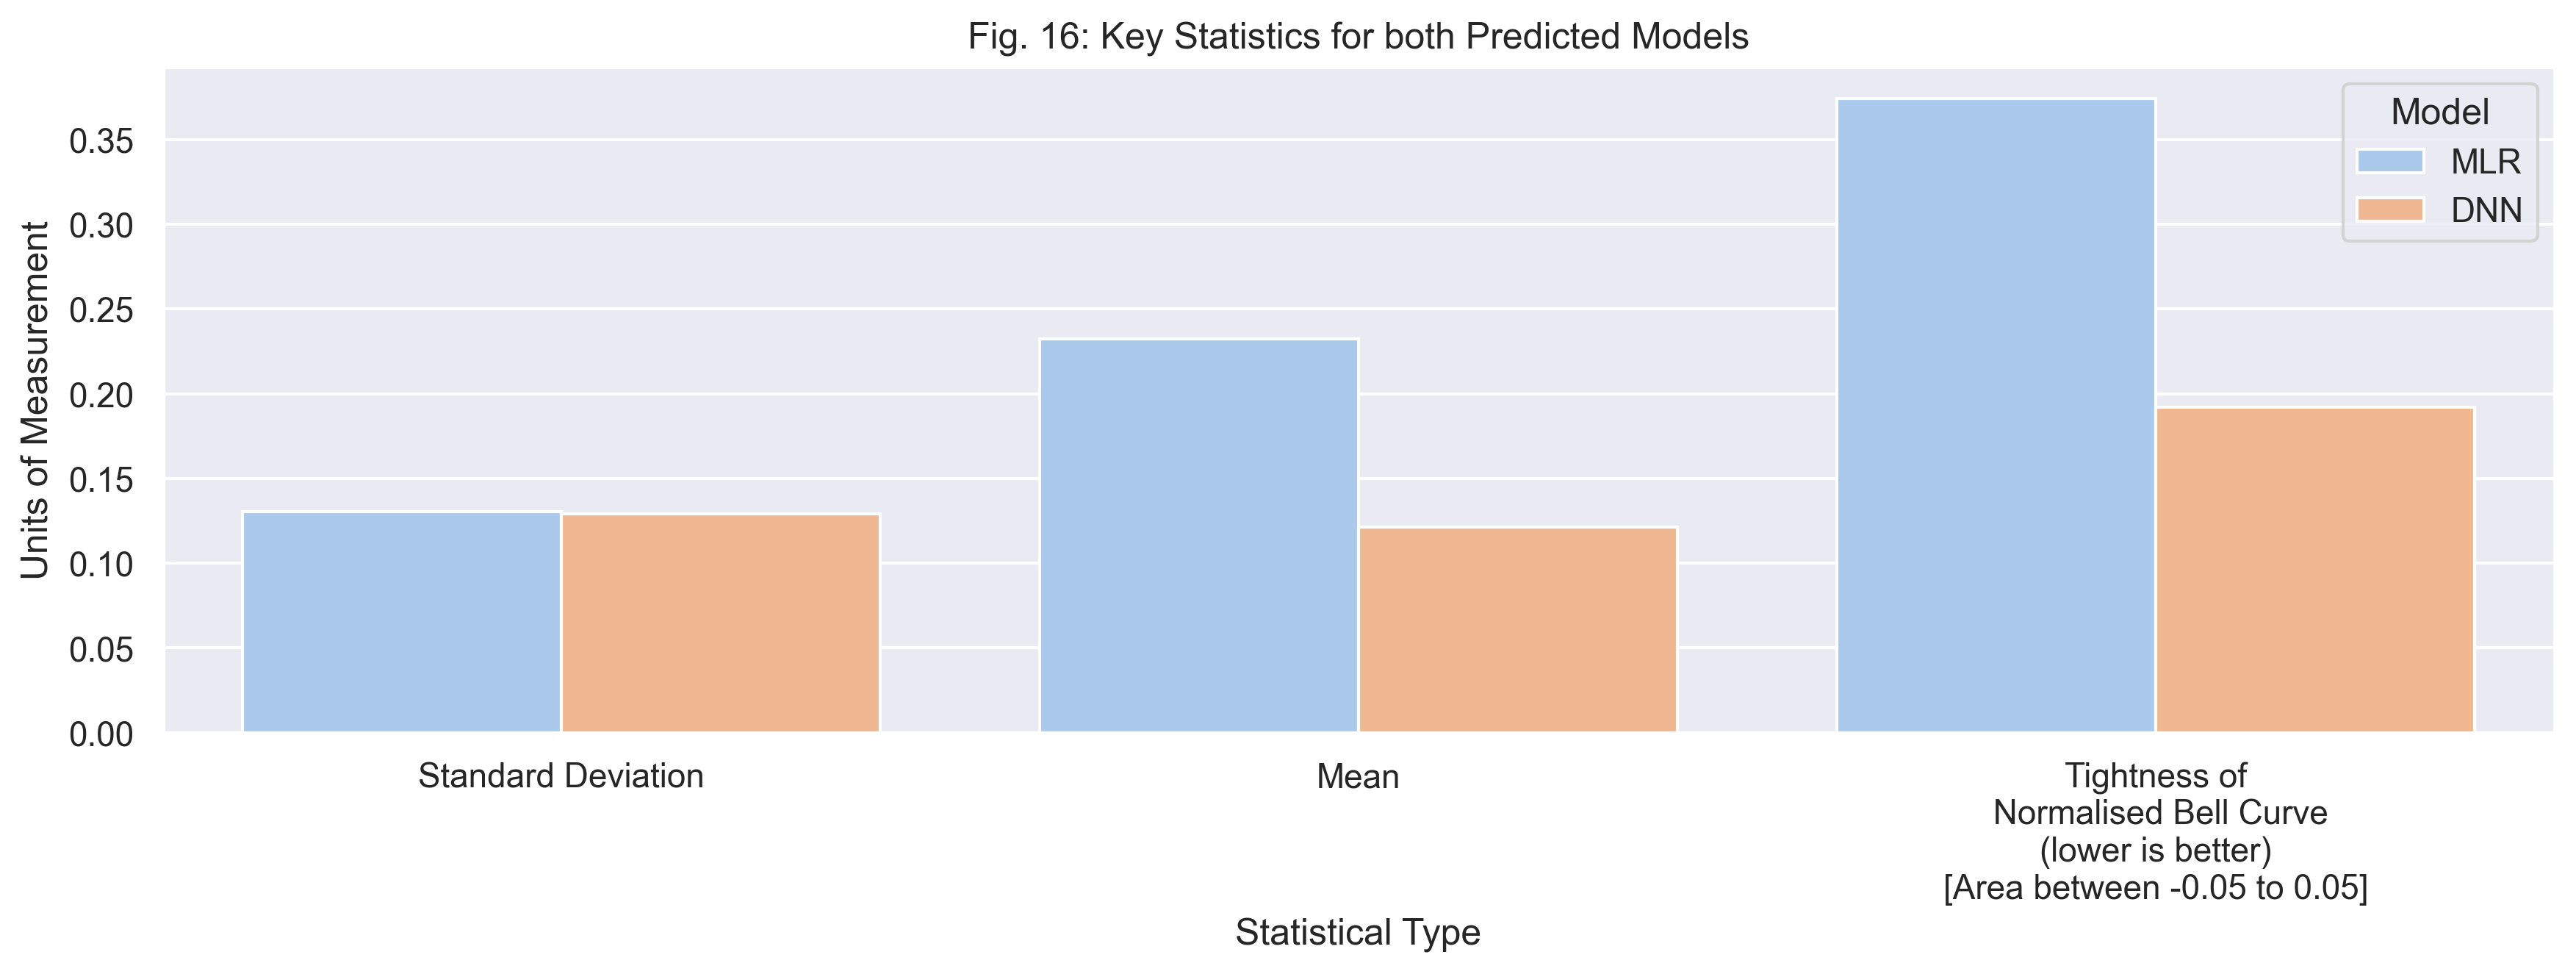

In [36]:
from scipy.stats import norm, t

sns.set_theme(style="darkgrid")

# Key stats
dnn_error = test_predictions - test_labels
mlr_error = residuals_reduced["predicted"] - residuals_reduced["actual"]

mlr_error_reshaped = mlr_error.values.reshape(-1, 1)
mlr_norm = MinMaxScaler().fit_transform(mlr_error_reshaped)

std_df_mlr = pd.DataFrame({"value": residuals_reduced_norm['predicted'].std(), "Model": "MLR", "type":"Standard Deviation"}, index=[0])
std_df_dnn = pd.DataFrame({"value": test_predictions.std(), "Model": "DNN", "type":"Standard Deviation"}, index=[0])

mean_df_mlr = pd.DataFrame({"value": residuals_reduced_norm['predicted'].mean(), "Model": "MLR", "type":"Mean"}, index=[0])
mean_df_dnn = pd.DataFrame({"value": test_predictions.mean(), "Model": "DNN", "type":"Mean"}, index=[0])

area_df_mlr = pd.DataFrame({"value": norm.cdf(x=mlr_norm.mean()+0.05, loc=mlr_norm.mean(), scale=mlr_norm.std()) - norm.cdf(x=mlr_norm.mean()-0.05, loc=mlr_norm.mean(), scale=mlr_norm.std()), "Model": "MLR", "type":"Tightness of\n Normalised Bell Curve\n(lower is better)\n[Area between -0.05 to 0.05]"}, index=[0])
area_df_dnn = pd.DataFrame({"value": norm.cdf(x=dnn_error.mean()+0.05, loc=dnn_error.std(), scale=dnn_error.std()) - norm.cdf(x=dnn_error.mean()-0.05, loc=dnn_error.std(), scale=dnn_error.std()), "Model": "DNN", "type":"Tightness of\n Normalised Bell Curve\n(lower is better)\n[Area between -0.05 to 0.05]"}, index=[0])

models_stats = pd.concat([
    std_df_mlr,
    std_df_dnn,
    mean_df_mlr,
    mean_df_dnn,
    area_df_mlr,
    area_df_dnn
])
figure(figsize=(14, 4), dpi=150)
sns.barplot(data=models_stats, x='type', y='value', hue='Model', palette='pastel')
plt.title("Fig. 16: Key Statistics for both Predicted Models")
plt.xlabel("Statistical Type")
plt.ylabel("Units of Measurement")
plt.show()

Figure 16 displays key statistics for both our MLR and DNN models. We will go through them one by one.
1. The first highlights the standard deviation (std) for both models. This is predominantly used as a safety check during fine tuning to see whether our dnn code spat out nonsense. However, from the above graph, we can see that our dnn has a similar std to that of our mlr.
2. Our second statictic demonstrates the mean. As mentioned in the previous dot point, this is primarily used as a check in fine tuning. Fig 16 denoted a notable increase in mean for our mlr whn compared to dnn. This, however, is due to our mlr over predicting a good portion of its results (as shown in the next graph), skewing its mean to the right. At the samee time, this highlights our dnn to be far more accurate than our mlr.
3. Our final statistic is a measure of the area beneath the bell curve (between x=0.5 and x=-0.5) for both models. In other words, it illustrates the tightness of the models' normalised bell curve (and how accurate their predictions are). From the above, we can extrapolate our mlr to have a far greater area (is more loose from the mean) when compared to our dnn model (more tightly packed towards the mean). Indicating our dnn to perform significantly better than our mlr model (as shown in the next few plots). This was especially useful in fine tuning our dnn to yield better results than our mlr.

#### Prediction Performance Analysis

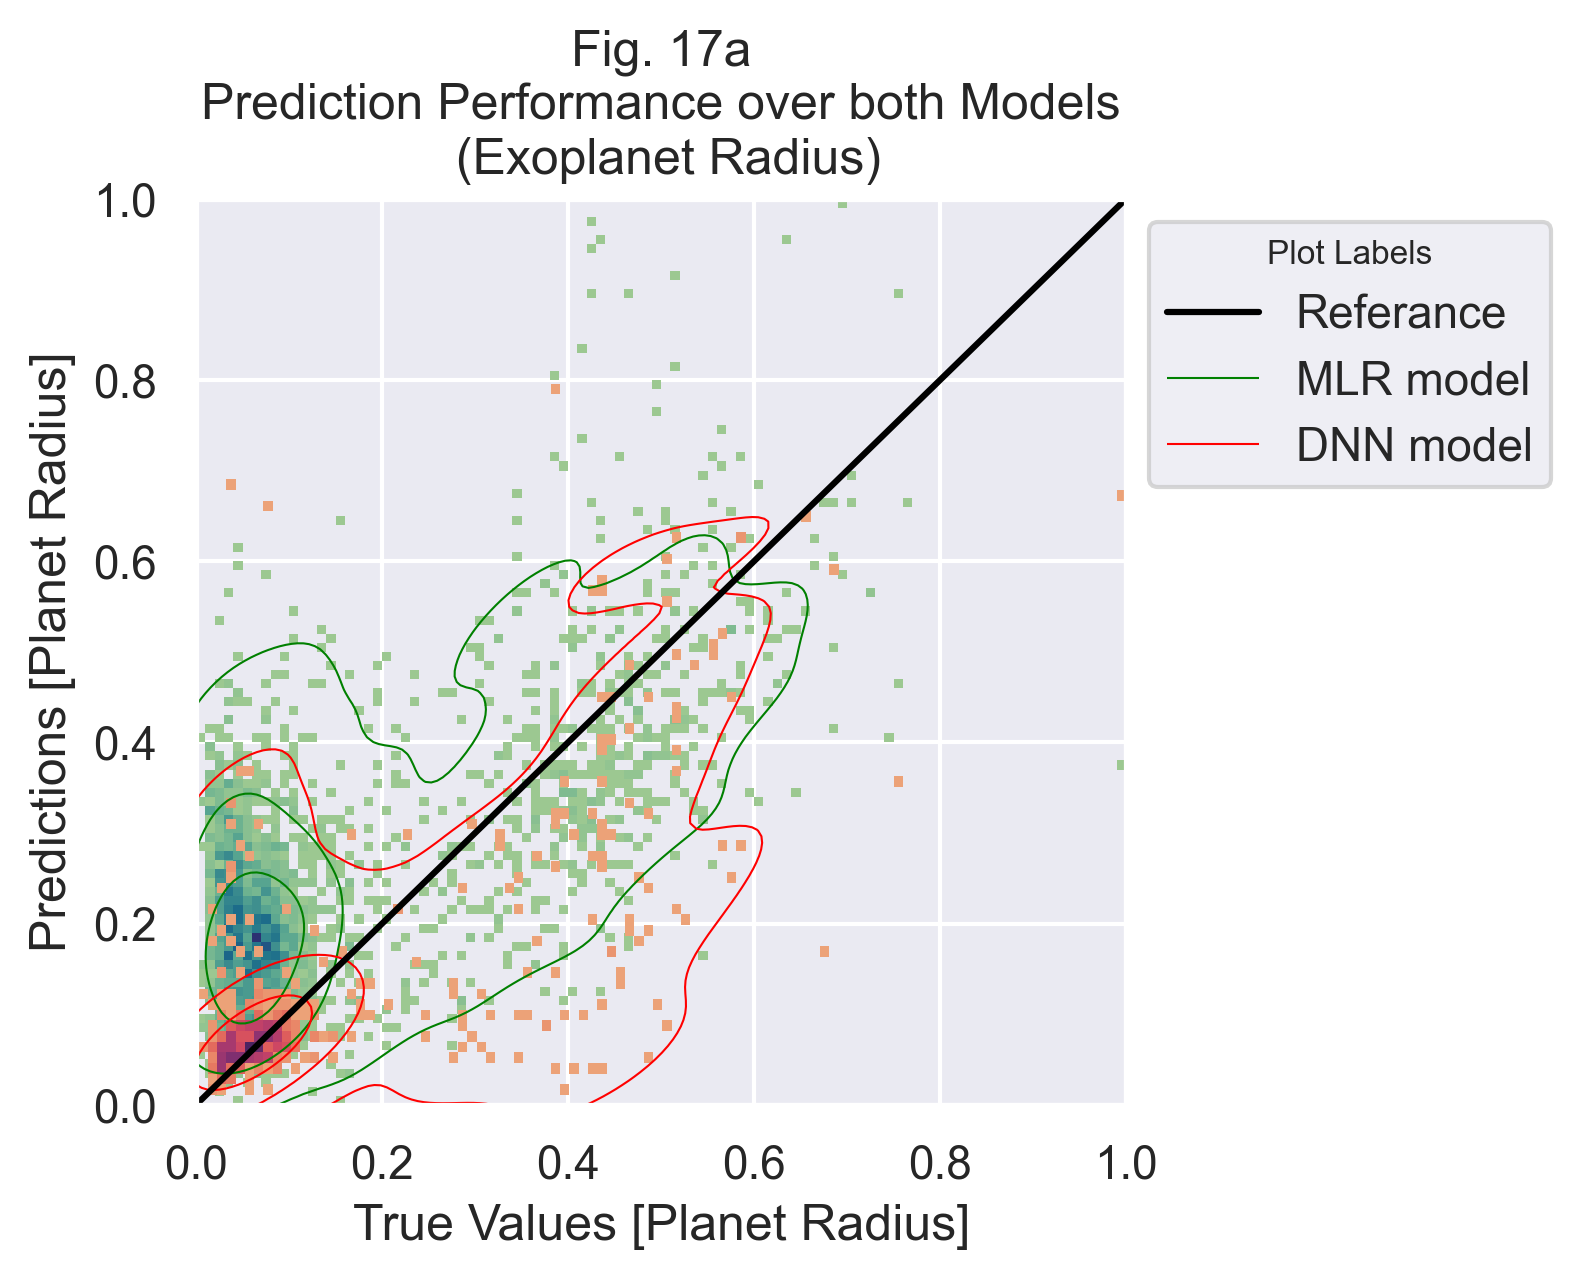

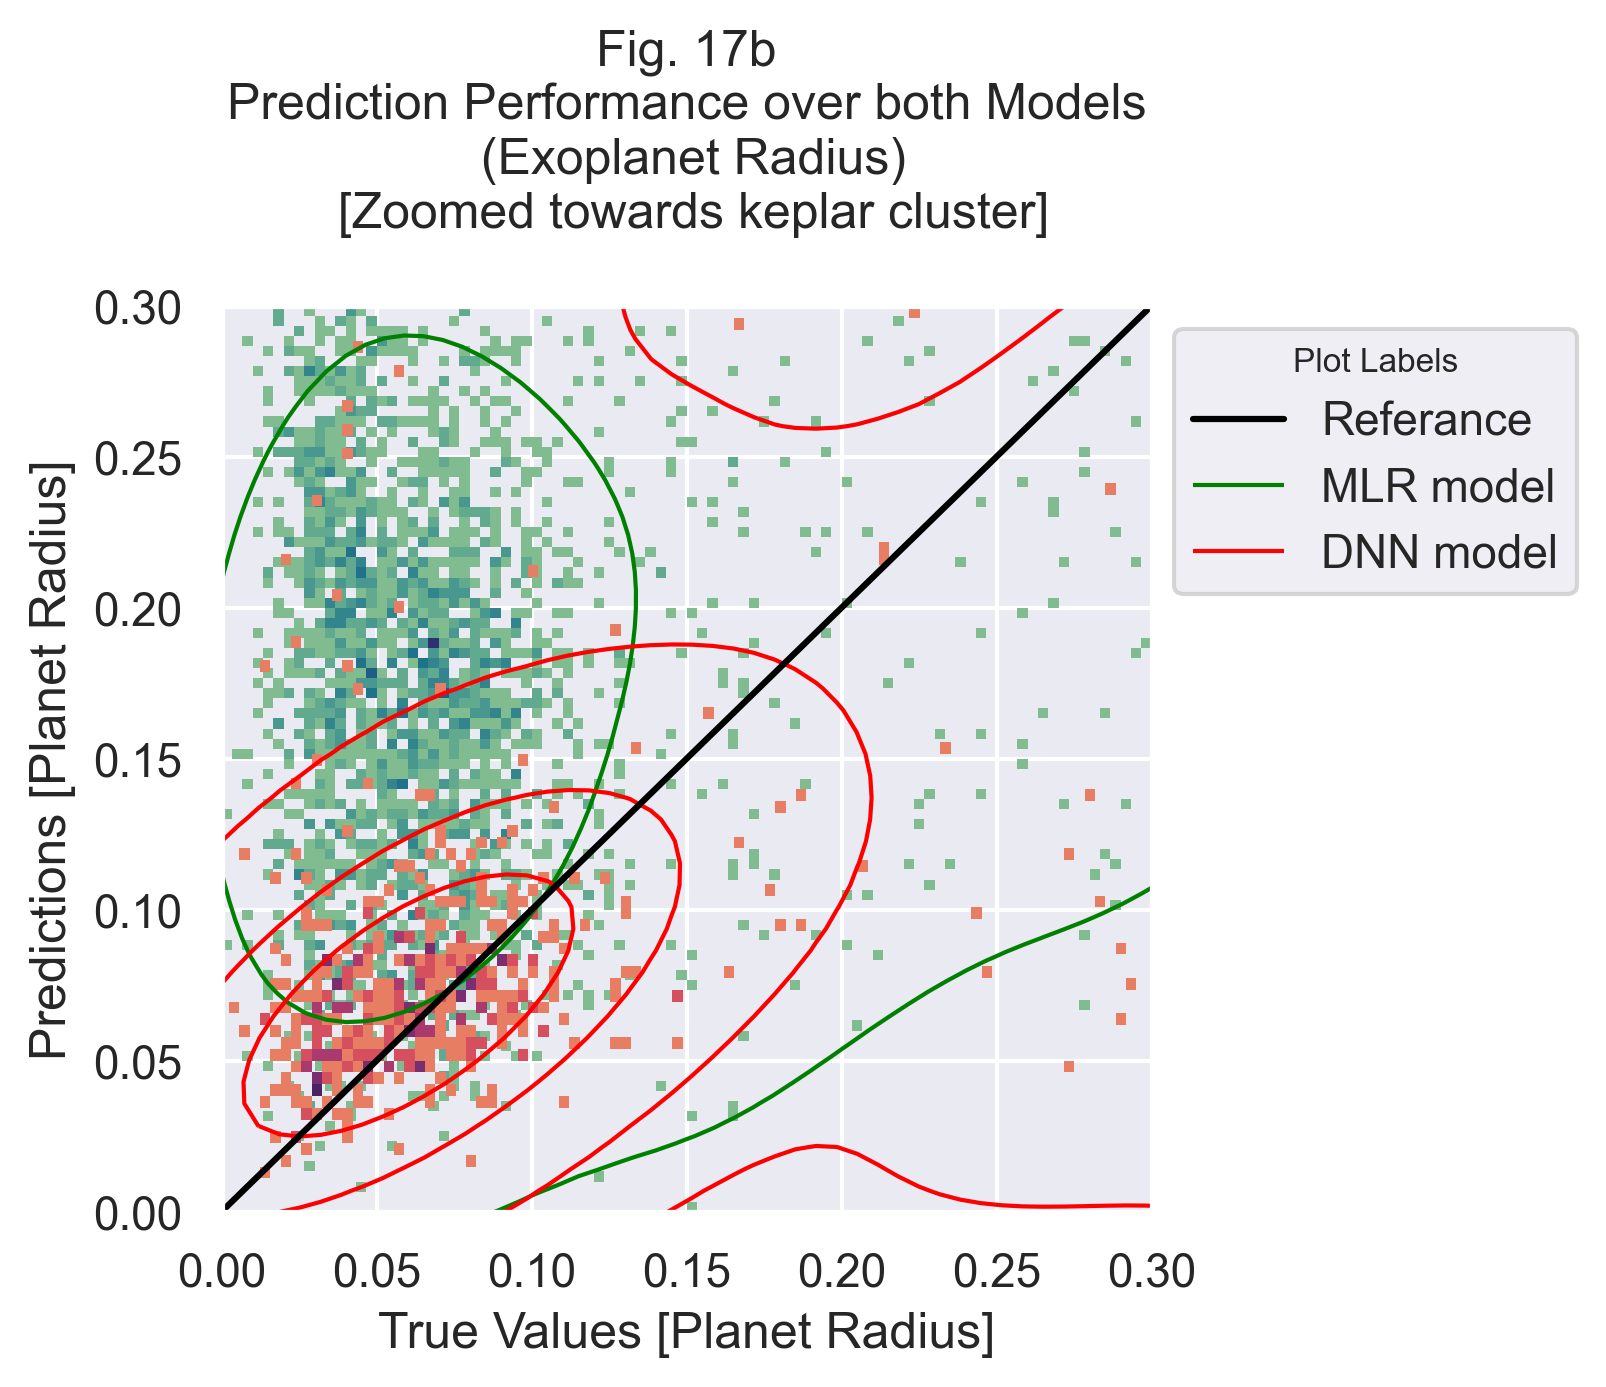

In [37]:
test_predictions = dnn_model.predict(test_features).flatten()

sns.set_theme(style="darkgrid")
figure(figsize=(4, 4), dpi=150)
# a = plt.axes(aspect='equal')
sns.histplot(data=residuals_reduced_norm, x='actual', y='predicted', bins=100, cmap="crest", label='MLR model')
sns.kdeplot(data=residuals_reduced_norm, x='actual', y='predicted', levels=4, color="green", linewidths=0.5)

sns.histplot(x=test_labels, y=test_predictions, bins=100, cmap="flare",  label='DNN model')
sns.kdeplot(x=test_labels, y=test_predictions, levels=4, color="red", linewidths=0.5)

plt.title("Fig. 17a\nPrediction Performance over both Models\n (Exoplanet Radius)")
plt.xlabel('True Values [Planet Radius]')
plt.ylabel('Predictions [Planet Radius]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='black')
plt.legend(labels=["Referance", "MLR model", "DNN model"], title = "Plot Labels", title_fontsize = "8", loc = 2, bbox_to_anchor = (1,1))
plt.show()

figure(figsize=(4, 4), dpi=150)
# a = plt.axes(aspect='equal')
sns.histplot(data=residuals_reduced_norm, x='actual', y='predicted', bins=300, cmap="crest")
sns.kdeplot(data=residuals_reduced_norm, x='actual', y='predicted', levels=3, color="green", linewidths=1)

sns.histplot(x=test_labels, y=test_predictions, bins=300, cmap="flare")
sns.kdeplot(x=test_labels, y=test_predictions, levels=5, color="red", linewidths=1)

plt.title("Fig. 17b\nPrediction Performance over both Models\n (Exoplanet Radius)\n [Zoomed towards keplar cluster]\n")
plt.xlabel('True Values [Planet Radius]')
plt.ylabel('Predictions [Planet Radius]')
lims = [0, 0.3]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='black')
plt.legend(labels=["Referance", "MLR model", "DNN model"], title = "Plot Labels", title_fontsize = "8", loc = 2, bbox_to_anchor = (1,1))
plt.show()


Figure 17 demonstrates the prediction performance for both of our models. Over here, we will call the black line the referance line, the green is MLR while red is our DNN. The y axis represents predictions made by the model, while the x indicates the true value (essentially, the closer it is to referance, the greater prediction performance the model has). Notice how the scale is between 0 and 1, resulting in 0.03 - 0.10 most likely representing planets around 3/4 to 4 times the size of planet earth. Each dot represents the model predicting an exoplanet exists under its corresponding, estimated radius.

Form both plots, it is evident that our dnn outperforms our mlr by a large margin. Our mlr model is seen to overpredict in its predictions, while making predictions over a larger range when compared to our dnn. This is further supported by our kde plots. Irregular rings on both models depicts the models primary prediction fields. In fig. 17b, our dnn seem to make predictions centered around the referance while our mlr places its fields over the referance. Interestingly, our dnn manages to understand patterns while predicting our outliers (in astronomy and given our dataset, the ability to predict larger, harder to detect planets in our universe makes our model more reliable and accurate). 

Fig. 17a better demonstrates larger planet prediction for both models. Compared to our dnn, the mlr makes frequent large planet predictions despite them being quite rare in our dataset. In stark contrast, our dnn focuses its predictions towards the keplar cluster, while still maing rare predictions for larger planets. However, while still predicting larger planets, both models clearly struggle in such prediction. 17a, clearly highlights an issue in which the models will try to create radical predictions for larger planets. While most predictions of large planets are fairly accurate, this is a limitation of the dataset that was used, which rarely captured extremelly large exoplanets.

Overall, the above plots plays as great evidence of our dnn outperforming our mlr. To our surprise, the dnn seem to make fairly accurate predictions for most of the outlier exoplanets in our dataset, however it does tend to underextimate as the target feature increases.

#### Residual Performance Analysis

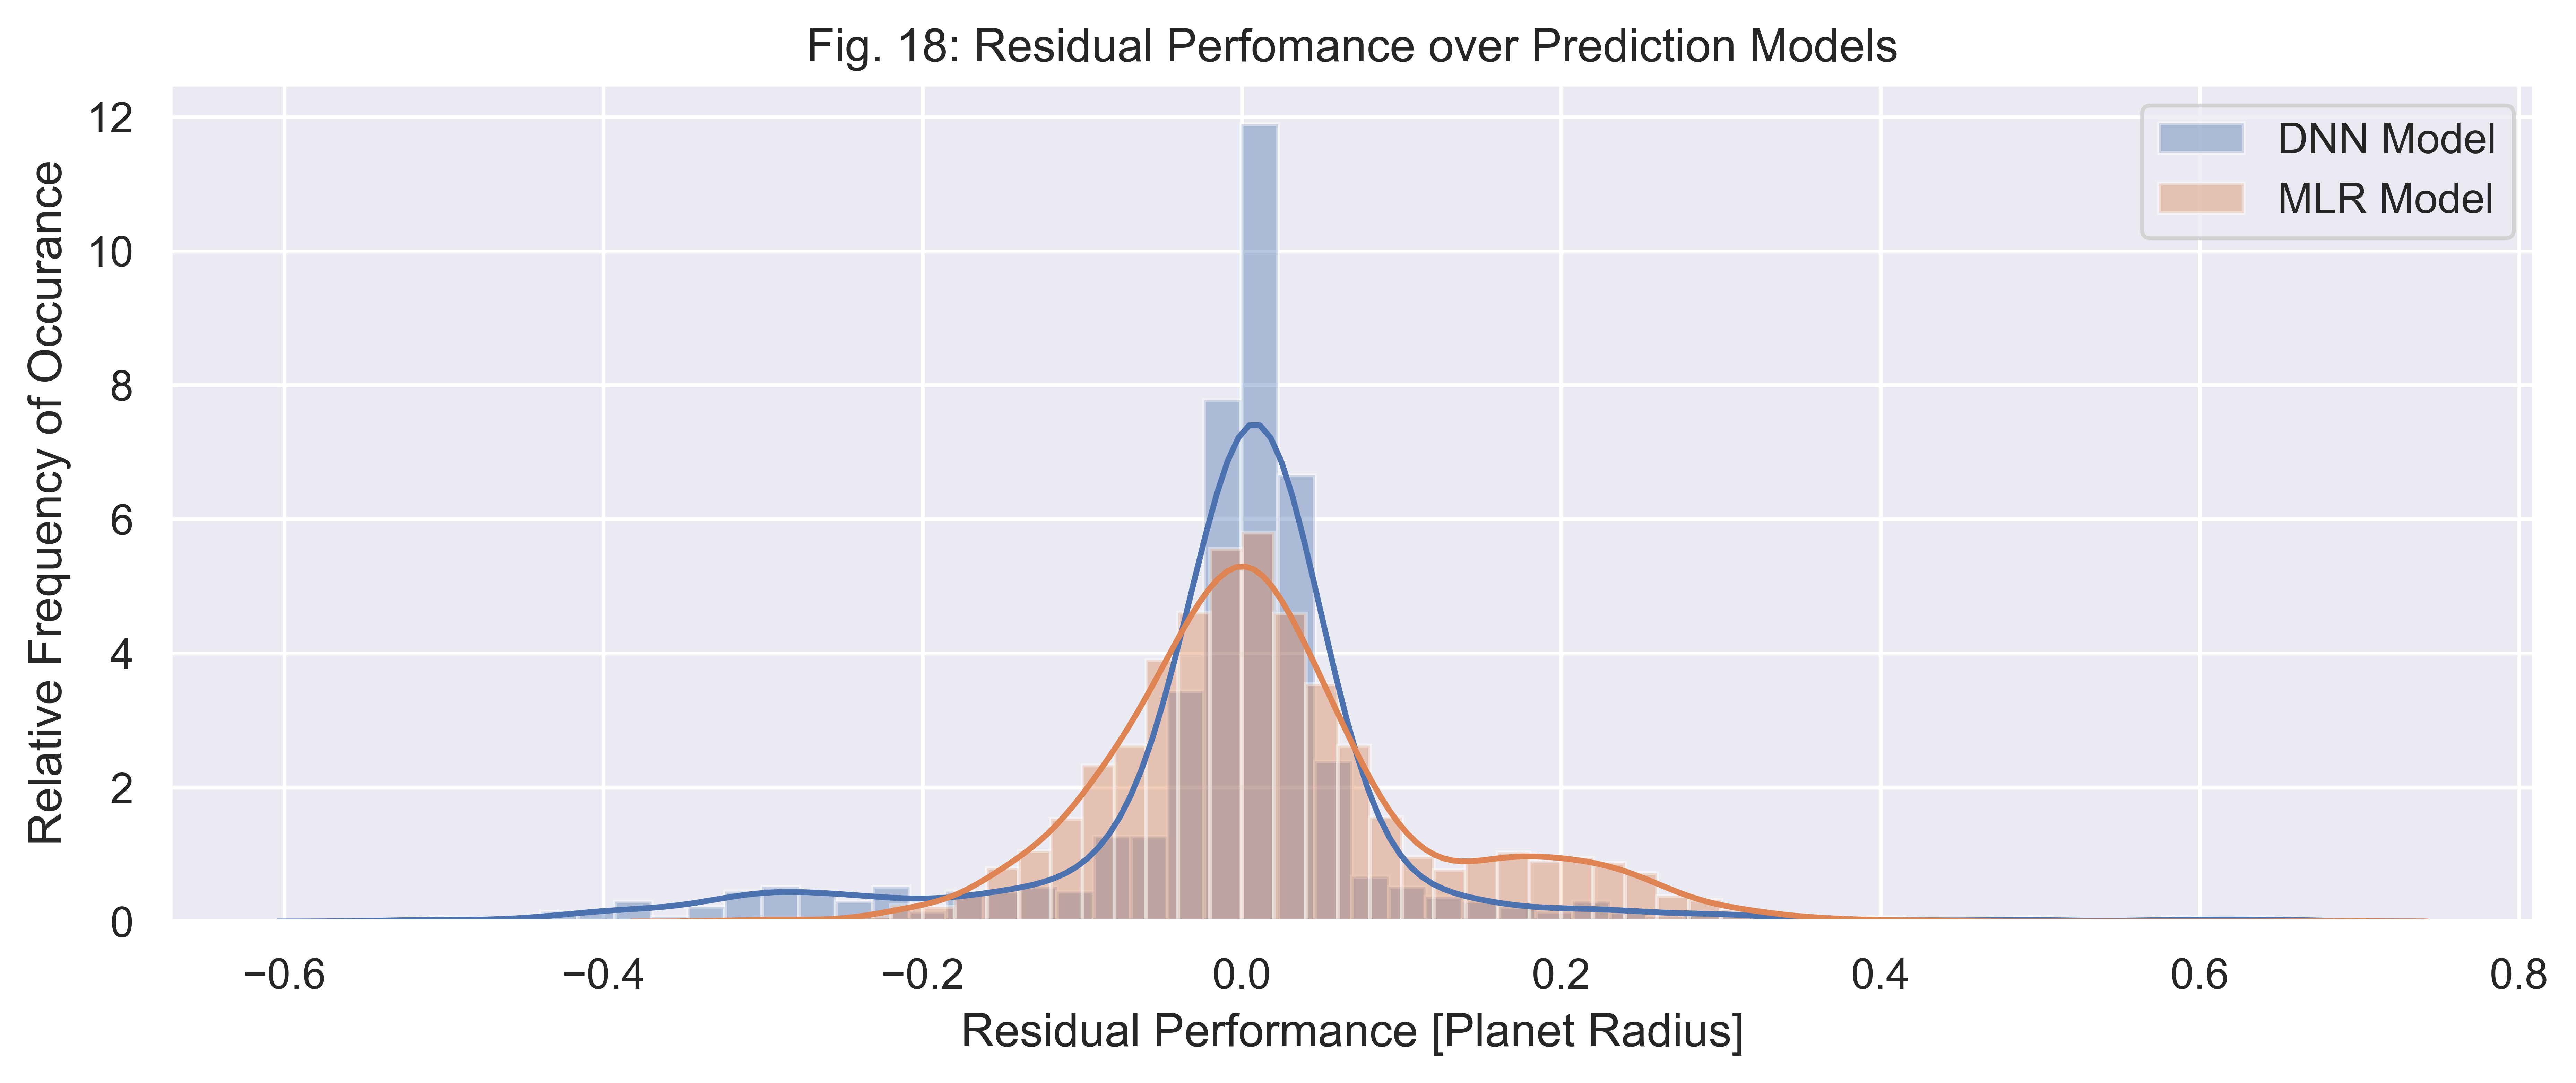

In [ ]:
dnn_error = test_predictions - test_labels
mlr_error = residuals_reduced["predicted"] - residuals_reduced["actual"]

mlr_error_reshaped = mlr_error.values.reshape(-1, 1)
mlr_norm = MinMaxScaler().fit_transform(mlr_error_reshaped)

sns.set_theme(style="darkgrid")
figure(figsize=(11, 4), dpi=400)

plt.title("Fig. 18: Residual Perfomance over Prediction Models")
sns.distplot(dnn_error, label="DNN Model")
sns.distplot((0.68-mlr_norm), label="MLR Model")
plt.xlabel('Residual Performance [Planet Radius]')
_ = plt.ylabel('Relative Frequency of Occurance')
plt.legend()
plt.show()

Figure 18 displays residual performance for both prediction models. The blue graph indicates our dnn while the orange is our mlr. 

The above clearly depicts our dnn containing a high frequency of near 0 residual, demostrating excellent residual performance. This is in direct comparision to the mlr, which demonstrates a wider residual curve, which is often indicative of lower accuracy. It is also interesting to note the tails of both distributions. Our dnn curve demonstrates an inflated tail on the left, which may indicate underestimation for larger planets. Meanwhile, the mlr demonstrates a noticeable bump on its right tail, which explains the extreme overestimation fhow in fig. 17b.

Overall, the residual performance graph signifies our fined tuned dnn having a much accurate performance when compared to our mlr.

### DNN Discussion (Literature)

#### Overview
This discussion will aim to inform the reader about the neural network that was used, its structure, the fine tuning process and other relevant decisions. Performance and limitations of the network will also be discussed.

#### Hyperparameters
Our deep neural network (dnn) made use of the following parameters.
1. Number of input nodes: 6

2. Hidden layer:
    - Number of hidden layers: 2
    - Number of nodes (neurons): 24
    - Activation type (both layers): Rectified Linear Activation Unit
    - Hidden layer 1 dropout: 0.015
    - Hidden layer 2 dropout: 0.000

3. Output layer:
    Number of nodes: 1
    - Activation: Linear
    
4. Compilation process:
    - Optimizer: Adaptive moment estimation (ADAM)
    
5. Model training:
    - Validation Split: 80 / 20 (%) → Training / Validation
    - Epochs: 150
    
- Total hyperparameter count: 11.

The decision using such parameters will be discussed in the process section.


#### DNN Structure

Our network contains a total of 55 nodes and 744 edges. Here is the structure:

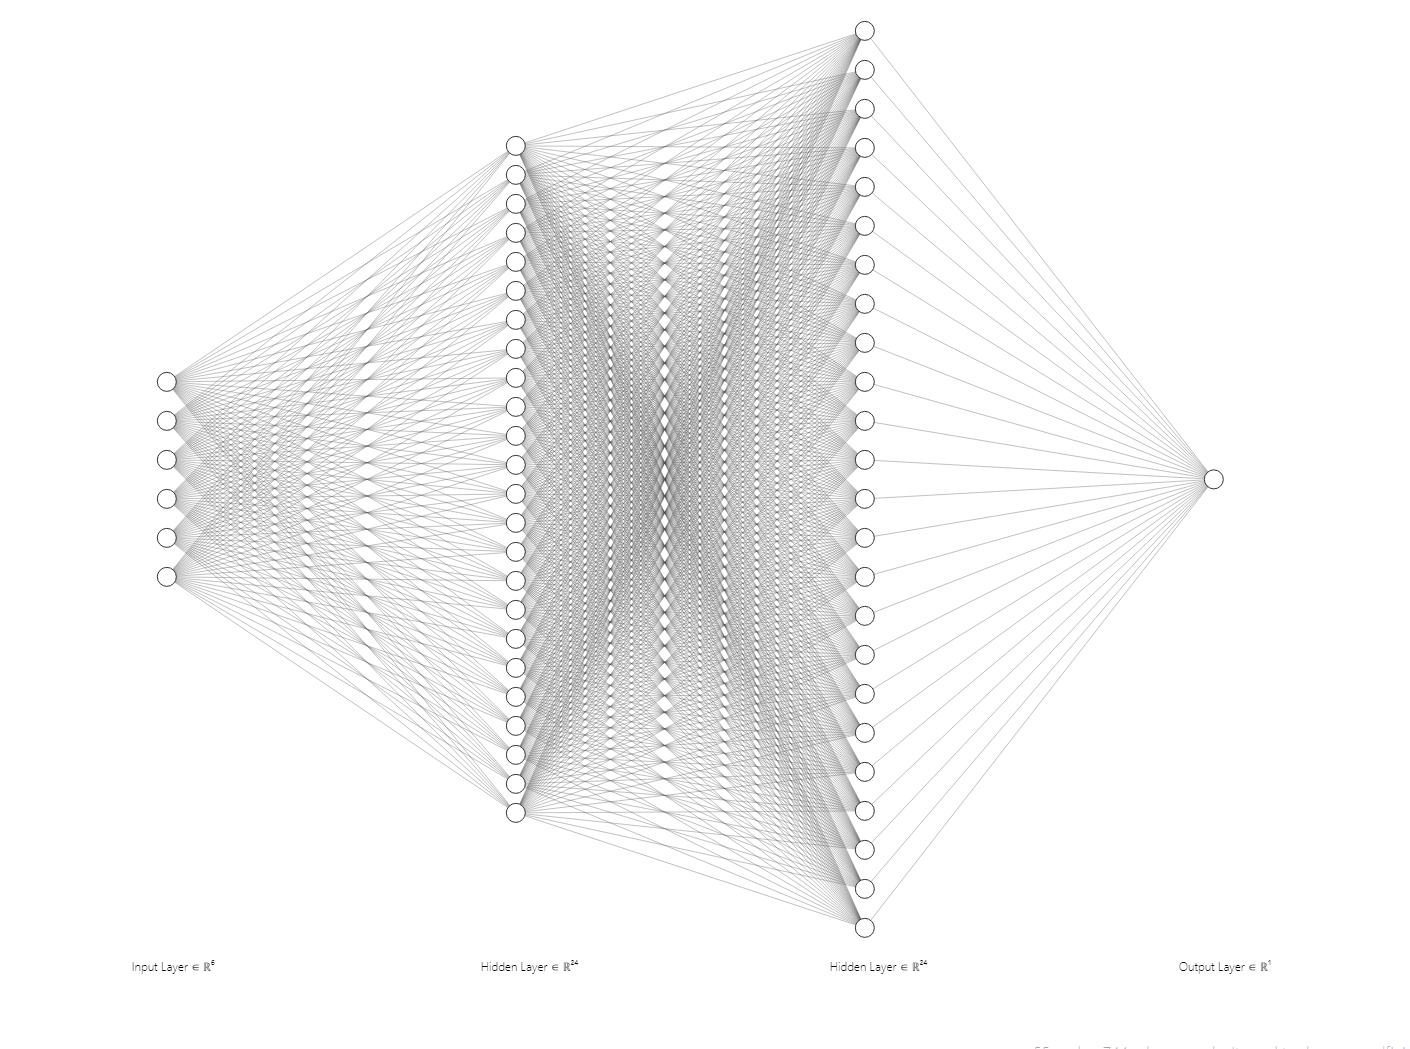

#### The Process Behind our DNN structure

As seen above, our dnn contains 6 input nodes followed by two hidden layers. Initially, we passed in 13 features making our network quite complex. This took a toll on accuracy and the network began to make quite radical predictions, which resulted in harsher, jagged lines for our loss graph, as shown below:

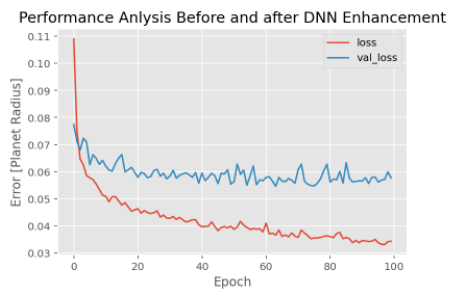

After this, we realised we were passing in columns that had little meaning towards our target feature, so we decided to prune the amount of features we passed in to about 6. This drastically stabilized our current loss graph:

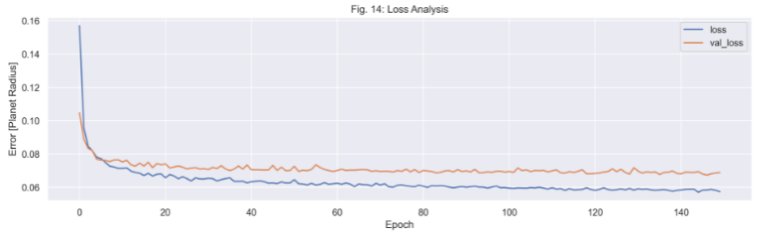

Adding dropouts in between hidden layers also helped in creating data that is more reliable. However, having a high dropout number resulted in the two lines merging together and warping in unsuspecting ways (they would become more jaggered for ex.). This led us to a number of 0.015 which gave us better prediction performance.

In terms of the amount of hidden layers, we initially experimented with 3 layers:

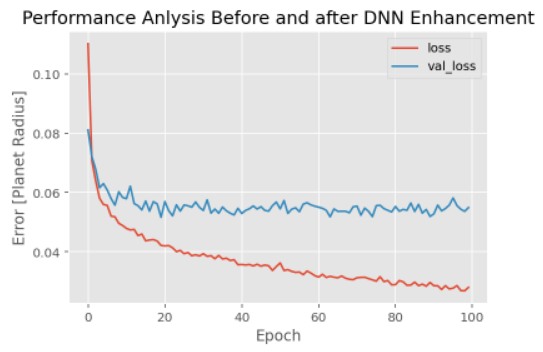

And even 5:

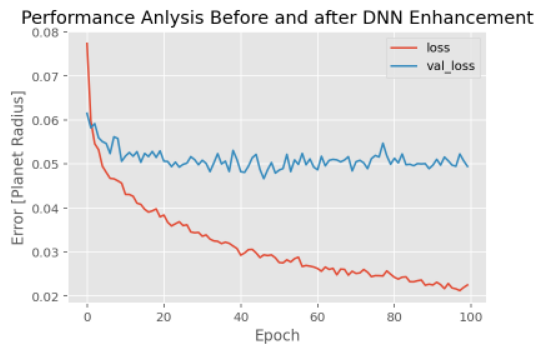

Even though we achieved a very good learning rate using 3 (or even 5 layers), it overcomplicated the network by a large factor. First off all, the network was failing to learn the data but just became really good at just memorising the training data. This led to very distant endpoints for both of our curves which we deemed undesirable. We decided on 2 hidden layers as it simplified the network (reduced jagged curves) and it allowed our val_loss and loss to more tightly stick together. This resulted in our dnn performing better on unseen data when compared to having a more complex model.

For the number of nodes, we initially tested out 64 nodes. After further experimentation, we doubled that value to 128. When simplifying our network however, we decided that an increase in nodes negatively affected the stability of our entire network, and resulted in a greater variance in predictions. After adjustments, we found 24 nodes gave us a nice middle ground between stability and prediction performance.

As our problem consisted of a linear regression, we utilised a single noded output with a linear activation function. Hidden layers also used relu as their activation function given our linear regression problem. Such a function allowed for the network to learn the complex relationships within our data better given our problem type. (https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)

During the compilation process, an Adam optimizer was chosen over SGD. While SGD worked desirably with our dataset, we found Adam to optimize the data in a more predictable fashion. As "[Adam] combines the advantages of [...] AdaGrad to deal with sparse gradients, and the ability of RMSProp to deal with non-stationary objectives" (https://arxiv.org/abs/1412.6980), we found Adam to better predict larger planets (outliers) more precisely when compared to SGD. It also improved the overall prediction performance of our NN by predicting exoplanets closer to the reference line in fig. 17.

Epochs played a great role in the way in which our dnn learned. A high number of 500 epochs was initially tested and yielded the following results:

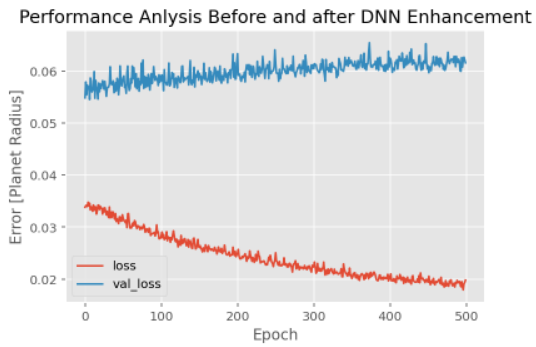

Such a high epoch number encouraged our network to memorise the training data rather than learn from it. This explains why the network progressively performs worse on data it has not seen before (error rate increases) when compared to the error rate from data it has learned from (error rate decreases). After experimenting with an epoch of 100, we realised the learning was cut off too shortly and therefore decided with an epoch of 150. This number consistently produced a reliable loss graph over multiple trials.

This concludes the discussion portion of our deep neural networks. Overall, we discussed the hyperparameters used, dnn topology, its structure, and the process behind tuning our dnn. Additional tuning graphs were provided to complement the discussion. 


---

## Critique & Limitations <a id='cl'></a>

The primary underlying flaw of this two phase report lies in our dataset. Historically, large clusters of planets are discovered based on missions that span over a specific period of time over a specific instrument. One of the instruments used to create our dataset was the Kepler Space Telescope. Kepler’s primary mission was to discover earth-like planets that may harbour extraterrestrial life. As a result, its discoveries were skewed towards smaller earth-like planets rather than larger planets (which are often uninhabitable). When graphing our target feature, this generated two dissimilar peaks that both of our models experienced trouble learning across. Our DNN performed noticeably better than our MLR in such cases. 

On another worthy note, it is worth mentioning how our dataset may not be truly representative of all exoplanets in the universe. Given Kepler’s mission and how exoplanets are truly dependent on certain features, our dataset may mostly have exoplanets that were more easily discoverable. A rogue planet with no star, planets orbiting a very dim or a smaller star may actually be far more common in the universe rather than regular planets in our dataset, but are just harder to record their existence. These planets may therefore seem much rarer to us even if they are more common in our universe.

In terms of strengths for our dnn model, it can create predictions based on our target with high accuracy. Unlike our MLR model, the dnn is not disturbed by the two different peaks in our datasets and accurately realises trends, especially for smaller exoplanets (fig. 17). While our model sometimes under-estimates exoplanet radius for larger planets, it still manages to mostly make fairly accurate predictions even for outliers.  Another notable strength is clustering. Our dnn model prefers to cluster its predictions over the reference line, making predictions far more accurate over the massive spread of predictions given out by MLR.

## Summary & Conclusions <a id='sc'></a>

### Project Summary

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

#### Phase 1
The summary for Phase 1 will be described in the following steps:
1. We first selected the type of dataset we would want to work with and then decided to build a custom dataset on the NASA's exoplanet archive database.
2. Afterwards, we decided on our target feature and goals and objectives. We initially made our target feature the number of planets in a single system but we soon relised that the data was in fact nominal categorical. Planet radius was then selected to be our target feature as other crucial properties (such as mass and orbital distance) may be denoted from a planets radius. An objective of predicting the size of discovered exoplanets based on features of the solar system. From this we can extarpolate linearly correlated features to determine our goal finding features that influence the xlixkelihood of planet discovery.
3. We than cleaned and processed the data for phase 2.
    - Unecessary columns were removed to make our dataset more focused and suitable for dnn and mlr models.
    - Columns were renamed to easy to read names.
    - Additional columns mass_ratio_sys and radius_ratio_sys were calculated
    - All NaN values were dropped.
4. Our data was then explored through a number of diffrent graphs. Some notable ones included:
    - Planet discoveries based upon their orbital period and orbital radius
    - Mass to radius relation for discovered planets
    - Exo-planet projected location in relation to the number of planets discovered in its system
5. Processed, phase 1 data was then processed to be used in phase 2.

#### Phase 2
The summary for Phase 2 will be described in the following steps:
1. Cateegorical values was one hot encoded into seperate columns.
2. We than used MinMaxScaler to normailse all numeric types in our dataset.
3. Feature selection was performed
    - A formula strin was created
    - Our model was then fitted to create a multi linear regression model (MLR)
    - Plots were created to measure the prediction performance of MLR
    - The accuracy of our model was then determined by calculating and plotting residuals
    - A further full model diagnostic check was performed to determine whether the model is healthy
4. Backwards feature selection was performed to remove features with a p value greater than 0.05.
    - Prediction performance after backwards feature selection was plotted to analyse any improvements / lack of improvements.
5. A Deep Neural Network was generated over the same dataset and target feature.
    - Specific data processing for NN was conducted (for ex. dropping of addtional columns tox increase the accuracy).
    - Partition of the dataset into training and testign datasets
    - NN model structure was built and compiled with approapiate parameters
    - DNN was then called to train on the training dataset
    - A combination of 5 graphs were used to fine tune the neural network and predict its performance realtive to our mlr.
    - A A discussion followed after, informing the reader the dnn used, its structure, the process in which the model was tuned and the hyperparameters used.
6. Limitations of our datset was explored followed by writing upon the strengths and weaknesses of our currrent models.


### Summary of Findings

Our objective was to predict the radius of a discovered exoplanet, and explore the features which most strongly affect this prediction. Due to the nature of our dataset, our MLR model was not accurate enough to fully explore this relationship, however some features were highly weighted.


Our R-squared value for our reduced model with 13 variables is 0.427. In this moderate strength model, semi_major_axis, orbital_period, star_mass, star_radius and distance play the largest role in predicting planet_radius. We predicted that as distance increases, planet radius would increase, but our findings contradict this. We do not know whether this would be the case if our dataset was unimodal. Semi_major_axis (or the average distance an exoplanet is from its star) was the strongest indicator of star size. Star radius and star mass were also highly weighted, which matches our predictions that larger stars would provide more detectable exo-planets.


The significantly higher accuracy of our neural network suggests that there are much better ways of predicting planet_radius than MLR with our chosen dataset features. This model accurately estimates the radius of exoplanets discovered by Kepler, whereas the MLR model overestimates these planets. 


### Conclusions

Your detailed conclusions as they relate to your goals and objectives.